# Setup enviorment

Mount your gdrive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


Git clone Our Repo

In [ ]:
!git clone https://github.com/mitcriticaldatacolombia/MIT_Multimodal_Satellite_Images_Fusion.git
%cd /content/gdrive/MyDrive/MIT_Multimodal_Satellite_Images_Fusion/

/content/gdrive/MyDrive/MIT_Multimodal_Satellite_Images_Fusion-M/MIT_Multimodal_Satellite_Images_Fusion


Installing some dependencies

In [ ]:
!pwd

/content/gdrive/MyDrive/MIT_Multimodal_Satellite_Images_Fusion-M/MIT_Multimodal_Satellite_Images_Fusion


In [ ]:
!pip install epiweeks
!pip install tensorflow-addons
!pip install keras-cv
!pip install keras_core
!pip install huggingface_hub
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00


In [ ]:
import os
import logging
import tensorflow as tf
# Set TensorFlow logging level to suppress debug messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '0' (default) shows all logs, '1' shows only warnings and errors, '2' shows only errors
# Disable logging of debug messages from TensorFlow
tf.get_logger().setLevel(logging.ERROR)
from Preprocessing.time_series_preprocessing import train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
import tensorflow as tf
import pandas as pd
import numpy as np

# Base LSTM

The code primarily focuses on building deep learning models for regression and classification tasks using LSTM (Long Short-Term Memory) layers. It provides utilities to create, compile, and train the models.

---

## Imports

- **TensorFlow and Keras**: Used for creating and training deep learning models.
- **TensorFlow Addons**: Provides extra functionalities not available in core TensorFlow.
- **Pretrained_DL_Models**: A custom module (not provided in the snippet) presumably containing pretrained models/backbones.
- **matplotlib**: For plotting graphs.
- **warnings**: For suppressing Python warnings.

---

## Custom Functions and Layers

1. **smape**:
    - A custom loss function representing the Symmetric Mean Absolute Percentage Error.

2. **CustomTimeDistributed**:
    - An inherited version of the Keras TimeDistributed layer that behaves differently if all input values are zeros.

3. **ZeroInputCheckLayer**:
    - A custom layer that checks if all input values are zeros. If they are, it returns a learnable vector; otherwise, it passes the input through the specified base CNN layer.

---

## Core Functions

1. **create_model**:
    - Creates and returns a deep learning model for regression.
    - Parameters:
        - `lstm_layers`: List specifying the number of LSTM units for each LSTM layer.
        - `nn_layers`: List specifying the number of neurons for each Dense layer.
        - Various other parameters to fine-tune the model's architecture and behavior.

2. **create_model_classification**:
    - Creates and returns a deep learning model for classification.
    - Parameters are similar to the `create_model` function but tailored for classification tasks.

3. **create_monitor**:
    - Creates an EarlyStopping callback for training the models. It stops training once a monitored quantity has stopped improving.
    - Parameters:
        - `monitor_var`: The metric to be monitored.
        - `min_delta`: Minimum change in the monitored quantity to qualify as an improvement.
        - `patience`: Number of epochs with no improvement after which training will be stopped.
        - Various other parameters to control its behavior.

4. **train_model**:
    - Trains a given model using the provided data and optionally plots the training and validation losses.
    - Parameters:
        - `model`: The Keras model to be trained.
        - `train_X`: Training data.
        - `train_y`: Labels for the training data.
        - `val_X`: Validation data.
        - `val_y`: Labels for the validation data.
        - Various other parameters to control the training process.

---

## Remarks

The code provides an extensive setup to easily create, compile, and train LSTM-based models for both regression and classification tasks. The provided utility functions and layers add extra functionalities like custom loss computations and dynamic behavior based on input values.

To use the code effectively, one needs to ensure they have TensorFlow and the necessary modules installed. Additionally, the `Models.Pretrained_DL_Models` module, which presumably contains the `get_backbone` function, needs to be available and correctly structured.


In [ ]:
# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, BatchNormalization, TimeDistributed
import tensorflow_addons as tfa

from Models.Pretrained_DL_Models import get_backbone

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

""" Create the Model for Regression """
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

""" Add the Learnable vector """
class CustomTimeDistributed(tf.keras.layers.TimeDistributed):
    def call(self, inputs):
        # Check if all values in the input are 0
        if tf.reduce_all(tf.equal(inputs, 0)):
            # Return the input without passing it through the cnn_base layer
            return inputs

        # Pass the input through the cnn_base layer and the rest of the layers
        else:
            return super().call(inputs)


# Custom Layer for zero input check
class ZeroInputCheckLayer(tf.keras.layers.Layer):
    def __init__(self, projection, cnn_base):
        super(ZeroInputCheckLayer, self).__init__()
        self.projection = projection
        self.cnn_base = cnn_base
        self.learnable_vector = self.add_weight(
            name='learnable_vector',
            shape=(projection,),
            trainable=True,
            initializer='zeros',
            constraint=tf.keras.constraints.NonNeg()
        )

    def call(self, inputs):
        print('tf.shape(inputs)',tf.shape(inputs))

        if tf.reduce_all(inputs == 0):
            outs = tf.expand_dims(self.learnable_vector, axis=0)
            print('tf.shape(outs)',tf.shape(outs))
            return outs
        else:
            outs = self.cnn_base(inputs)
            print('tf.shape(outs)',tf.shape(outs))
            return outs



def create_model(lstm_layers=[256,128,64], nn_layers=[60, 1], sequence=3, features=1024, dense_acivation='relu', recurrent_cells='LSTM', bidirectional=False, backbone='ResNet50V2', weights='imagenet', freeze=True, projection=1024, learnable_vector=False, meta_features = False):

    # Create a Sequential Model
    model = Sequential()


    if type(features) == list or type(features) == tuple and sequence != 0:
        # Get backbone:
        # Possible options to backbone: # 'ViT' # 'ConvNeXtTiny' # 'ConvNeXtSmall' # 'ConvNeXtBase' # 'ResNet50V2' # 'VGG16' # 'MobileNetV2'
        # Possible options to weights: # 'imagenet' # None # 'sentinel_vae' # 'sentinel_ae'
        #backbone = 'ConvNeXtTiny' # 'ViT' # 'ConvNeXtTiny' # 'ConvNeXtSmall' # 'ConvNeXtBase' # 'ResNet50V2' # 'VGG16' # 'MobileNetV2'
        #weights = 'imagenet' # 'imagenet' # None # 'sentinel_vae' # 'sentinel_ae'
        #freeze = False
        cnn_base = get_backbone(features, backbone, freeze=freeze, weights=weights)

        if learnable_vector:
            model.add(TimeDistributed(ZeroInputCheckLayer(projection, cnn_base), input_shape=((sequence,) + features)))
        else:
            model.add(TimeDistributed(cnn_base, input_shape = ((sequence,) + features)))
        # Projection layer
        model.add(tf.keras.layers.TimeDistributed(Dense(projection)))
        # model.add(tf.keras.layers.LSTM(120, dropout=0.1, return_sequences=True))
        features = projection


    if sequence != 0:
        # Add LSTM Layers
        for i, lstm_layer in enumerate(lstm_layers):
            if i < (len(lstm_layers) - 1):
                if bidirectional:
                    if recurrent_cells == 'LSTM':
                        model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                    elif recurrent_cells == 'GRU':
                        model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                    else:
                        model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                else:
                    if recurrent_cells == 'LSTM':
                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                    elif recurrent_cells == 'GRU':
                        model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                    else:
                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                features = lstm_layer
            else:
                if bidirectional:
                    if recurrent_cells == 'LSTM':

                          model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                    elif recurrent_cells == 'GRU':
                        model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                    else:
                        model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                else:
                    if recurrent_cells == 'LSTM':

                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                    elif recurrent_cells == 'GRU':
                        model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                    else:
                        model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
    else:
      if meta_features == False:
          for i, nn_layer in enumerate(lstm_layers):
              if i < (len(nn_layers) - 1):
                  model.add(Dense(nn_layer, activation=dense_acivation))
                  # model.add(BatchNormalization())
              else:
                  model.add(Dense(nn_layer))
      else:
          for i, nn_layer in enumerate(nn_layers):
              if i < (len(nn_layers) - 1):
                  model.add(Dense(nn_layer,   kernel_initializer='lecun_normal', activation='selu'))
                  model.add(BatchNormalization())
              else:
                  model.add(Dense(nn_layer))
    # model.add(BatchNormalization())
    # Add Dense Layers
    if meta_features == False:
      for i, nn_layer in enumerate(nn_layers):
          if i < (len(nn_layers) - 1):
              model.add(Dense(nn_layer, activation=dense_acivation))
              model.add(BatchNormalization())
          else:
              model.add(Dense(nn_layer))
    else:

      for i, nn_layer in enumerate(nn_layers):
          if i < (len(nn_layers) - 1):
              model.add(Dense(nn_layer,   kernel_initializer='lecun_normal', activation='selu'))
              model.add(BatchNormalization())
          else:
              model.add(Dense(nn_layer))

    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam(lr=0.001)
    else:
        opt = tf.keras.optimizers.Adam(lr=0.001)


    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        smape
    ]

    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model


""" Create the Model for Classification """
def create_model_classification(lstm_layers=[120, 240], nn_layers=[60, 3], sequence=3, features=1024, dense_acivation='relu', recurrent_cells='LSTM', bidirectional=False):

    # Create a Sequential Model
    model = Sequential()

    # Add LSTM Layers
    for i, lstm_layer in enumerate(lstm_layers):
        if i < (len(lstm_layers) - 1):
            if bidirectional:
                if recurrent_cells == 'LSTM':
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                elif recurrent_cells == 'GRU':
                    model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
                else:
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True)))
            else:
                if recurrent_cells == 'LSTM':
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                elif recurrent_cells == 'GRU':
                    model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
                else:
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features), return_sequences=True))
            features = lstm_layer
        else:
            if bidirectional:
                if recurrent_cells == 'LSTM':
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                elif recurrent_cells == 'GRU':
                    model.add(Bidirectional(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
                else:
                    model.add(Bidirectional(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features))))
            else:
                if recurrent_cells == 'LSTM':
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                elif recurrent_cells == 'GRU':
                    model.add(GRU(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
                else:
                    model.add(LSTM(lstm_layer, dropout=0.1, input_shape=(sequence, features)))
    model.add(BatchNormalization())
    # Add Dense Layers
    for i, nn_layer in enumerate(nn_layers):
        if i < (len(nn_layers) - 1):
            model.add(Dense(nn_layer, activation=dense_acivation))
            model.add(BatchNormalization())
        else:
            model.add(Dense(nn_layer, activation='softmax'))

    # Compile the model:
    if int(tf.__version__.split('.')[1]) >= 11:
        opt = tf.keras.optimizers.legacy.Adam()
    else:
        opt = tf.keras.optimizers.Adam()

    # Metrics
    metrics = [
        tf.keras.metrics.AUC(name='auc'), #, multi_label=True, num_labels=3),
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tfa.metrics.F1Score(num_classes=3, threshold=0.5)
        ]

    #loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)


    return model



""" Train the Model """
def create_monitor(monitor_var='val_loss', min_delta=1e-3, patience=8, verbose=1, mode='auto', restore_best_weights=True):
    # EarlyStopping:
    monitor = EarlyStopping(monitor=monitor_var, min_delta=min_delta, patience=patience,
                            verbose=verbose, mode=mode, restore_best_weights=restore_best_weights)
    return monitor

# fit network
def train_model(model, train_X, train_y, val_X, val_y, monitor, plot=None, epochs=50, batch_size=16, verbose=0, weights=None):
    if monitor:
        monitor = create_monitor()
        if weights:
            history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose, shuffle=False, callbacks=[monitor], class_weight=weights)
        else:
            history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose, shuffle=False, callbacks=[monitor], class_weight=weights)
    else:
        history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), verbose=verbose, shuffle=False)

    if plot:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Train - Validation Loss Plot')
        plt.legend()
        plt.show()





# Create Aggregate Models

Deep learning architectures that focus on merging and aggregating the outputs from various models using techniques such as attention mechanisms.

## 1. Imports

Libraries and modules required to create and handle the deep learning models.

## 2. Custom SMAPE Loss Function

Symmetric Mean Absolute Percentage Error (SMAPE) is a custom loss function which measures the accuracy of predictions.

## 3. Attention and Fusion Models

### 3.1. Gated Attention Network

A neural network architecture that utilizes a gating mechanism over the attention weights.

### 3.2. Fusion Network

A neural network architecture that merges features using a specific mechanism.

## 4. Kronecker Product Layer

Layer that computes the outer product between two tensors.

## 5. Model Aggregation Functions

### 5.1. Regression Aggregation Model

Function that aggregates features from multiple models and generates a final regression output.

### 5.2. Attention-based Regression Aggregation Model

This function integrates an attention mechanism while aggregating features from multiple models.

### 5.3. Classification Aggregation Model

Function to merge outputs of various models for classification tasks.

## Remarks:

- The main purpose of the provided code is to aggregate or fuse outputs from various models.
- Attention mechanisms are used to assign different importances to different features while fusing.
- The models and functions are flexible enough to handle up to three input models.
- Aggregation can be done for both regression and classification tasks.

Make sure to adjust the models and functions according to the specific requirements of your tasks and datasets. Additionally, ensure that the necessary libraries and dependencies are installed.


In [ ]:
# Deep learning
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers import Dense, concatenate, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt

""" Create the Model """
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

class Attn_Net_Gated(tf.keras.Model):
    def __init__(self, L=1024, D=256, dropout=0., n_classes=1):
        super(Attn_Net_Gated, self).__init__()

        self.attention_a = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('tanh'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_b = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_a = tf.keras.Sequential(self.attention_a)
        self.attention_b = tf.keras.Sequential(self.attention_b)

        self.attention_c = tf.keras.layers.Dense(n_classes)

    def call(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = tf.multiply(a, b)
        A = self.attention_c(A)
        return A

class Fusion_Net(tf.keras.Model):
    def __init__(self, L=1024, D=256, dropout=0., n_classes=1):
        super(Fusion_Net, self).__init__()

        self.attention_a = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('tanh'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_b = [
            tf.keras.layers.Dense(D),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dropout(dropout)
        ]

        self.attention_a = tf.keras.Sequential(self.attention_a)
        self.attention_b = tf.keras.Sequential(self.attention_b)

        self.attention_c = tf.keras.layers.Dense(n_classes)

    def call(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = tf.multiply(a, b)
        A = self.attention_c(A)
        return A

# Defines the Kronecker product
from tensorflow.keras.layers import Layer
class OuterProductLayer(Layer):
    def __init__(self):
        super(OuterProductLayer, self).__init__()

    def call(self, inputs):
        # Assuming inputs is a tuple of two tensors
        output1, output2 = inputs
        ones_tensor = tf.ones((tf.shape(output1)[0], 1), dtype=output1.dtype)
        ones_tensor = tf.stop_gradient(ones_tensor)
        # Concatenate the ones tensor with the input vectors
        output1 = tf.concat([ones_tensor, output1], axis=1)
        ones_tensor2 = tf.ones((tf.shape(output1)[0], 1), dtype=output1.dtype)
        ones_tensor2 = tf.stop_gradient(ones_tensor2)
        # Concatenate the ones tensor with the input vectors
        output2 = tf.concat([ones_tensor, output2], axis=1)
        outer_product = tf.einsum('bi,bj->bij', output1, output2)
        return Flatten()(outer_product)

def create_aggregation_model(model, model_2, model_3=None, fusion=None, dense_acivation='relu'):

    L=128
    D=64

    print(model.summary(), "model1 sum")

    if fusion == 'early' or 'joint':
        modelc = Sequential(model.layers[:-1])
        modelc.trainable = False
        model_2c = Sequential(model_2.layers[:-1])
        model_2c.trainable = False
        if model_3:
            model_3 = Sequential(model_3.layers[:-1])
            model_3.trainable = False

    if model_3:
        input3 = model_3.input
        out_3 = model_3(input3)
    # Create a Sequential Model
    input1 = modelc.inputs
    input2 = model_2c.input
    out_1 = modelc(input1)
    out_2 = model_2c(input2)
    out_1c = model(input1)
    out_2c = model_2(input2)

    fusion_features = OuterProductLayer()((out_1,out_2))
    print(fusion_features.shape)



    # Assuming self.fusion_fc is a Keras layer
    x = Dense(256, activation=dense_acivation)(fusion_features)

    x = Dense(128, activation=dense_acivation)(x)
    x = concatenate([x,out_1c,out_2c])
    x = Dense(64, activation=dense_acivation)(x)

    x = Dense(32, activation=dense_acivation)(x)

    x = Dense(16, activation= dense_acivation)(x)
    output_layer = Dense(1)(x)

    #Model Definition
    final_model = Model(inputs=[(input1, input2)], outputs=[output_layer])


    # Compile the model:
    opt = keras.optimizers.Adam()

    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        smape
    ]

    final_model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return final_model

def create_aggregation_model_attention(model, model_2, model_3=None, fusion=None, dense_acivation='relu'):

    L=128
    D=64


    if fusion == 'early' or 'joint':

        modelc = Sequential(model.layers[:-1])
        modelc.trainable = False
        model_2c = Sequential(model_2.layers[:-1])
        model_2c.trainable = False
        if model_3:

            model_3 = Sequential(model_3.layers[:-1])
            model_3.trainable = False

    if model_3:
        input3 = model_3.input
        out_3 = model_3(input3)

    input1 = modelc.inputs
    input2 = model_2c.input
    out_1 = modelc(input1)
    out_2 = model_2c(input2)
    out_1f = model(input1)
    out_2f = model_2(input2)

    h = tf.keras.layers.Dense(L)(out_1)
    A = Attn_Net_Gated(L, D, dropout=0.2, n_classes=1)(out_1)

    A = tf.nn.softmax(A, axis=1)
    atten_out = A*out_1
    fusion_features = OuterProductLayer()((atten_out,out_2))
    # Assuming self.fusion_fc is a Keras layer
    x = Dense(256, activation=dense_acivation)(fusion_features)
    x = Dense(128, activation=dense_acivation)(x)
    x = concatenate([x,out_1f,out_2f])
    x = Dense(64, activation=dense_acivation)(x)
    x = Dense(32, activation=dense_acivation)(x)
    x = Dense(16, activation=dense_acivation)(x)
    output_layer = Dense(1)(x)
    #Model Definition
    final_model = Model(inputs=[(input1, input2)], outputs=[output_layer])
    # Compile the model:
    opt = keras.optimizers.Adam()

    # Metrics
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        smape
    ]

    final_model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return final_model

def classification_aggregation(model, model_2, model_3=None, fusion=None, dense_acivation='relu'):


    # Create a Sequential Model
    input1 = model.inputs
    input2 = model_2.input

    if fusion == 'early' or 'joint':
        model.layers.pop()
        model_2.layers.pop()
        if model_3:
            model_3.layers.pop()

    if model_3:
        input3 = model_3.input
        out_3 = model_3(input3)

    out_1 = model(input1)
    out_2 = model_2(input2)

    if model_3:
        concat_x = concatenate([out_1, out_2, out_3])
    else:
        concat_x = concatenate([out_1, out_2])

    #Final Layer
    x = Dense(6, activation=dense_acivation)(concat_x)
    output_layer = Dense(3, activation='softmax')(x)

    #Model Definition
    if model_3:
        final_model = Model(inputs=[(input1, input2, input3)], outputs=[output_layer])
    else:
        final_model = Model(inputs=[(input1, input2)], outputs=[output_layer])

    # Compile the model:
    opt = keras.optimizers.Adam()

    # Metrics
    metrics = [
        tf.keras.metrics.AUC(name='auc'), #, multi_label=True, num_labels=3),
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tfa.metrics.F1Score(num_classes=3, threshold=0.5)
        ]

    #loss = tf.keras.losses.SparseCategoricalCrossentropy()

    final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)


    return final_model

# Model Testing

In this section, we aim to test and evaluate the performance of our model against test data. We will use a series of metrics such as RMSE, MAE, sMAPE, and R^2. The section is organized as follows:

1. **Prediction Generation**: Use the trained model to forecast on test data.
2. **Performance Metrics**: Compute various metrics to evaluate model performance.
3. **Time Series Plot**: Visualize the real vs. predicted values.

## Generate Predictions

The function `test_model` is employed to generate predictions using the trained model. It's designed to handle both RNNs and classical machine learning models. For classification problems, it can decode the predicted labels and for regression models, it inverses the scaling applied during pre-processing.

## Performance Metrics

We use a series of metrics to gauge the performance of our model:

- **Mean Absolute Percentage Error (MAPE)**
- **Symmetric Mean Absolute Percentage Error (sMAPE)**
- **Mean Absolute Error (MAE)**
- **R Squared (R^2)**
- **Root Mean Squared Error (RMSE)**

Each of the above metrics provides a unique perspective on the model's error rates and fit quality.

## Plot Time Series of Predictions

The function `plot_predictions` plots a time series graph showing the actual vs. predicted values. This visual representation can help understand the model's prediction patterns over time.

## Model Evaluation

The function `evaluate` combines the prediction generation and metric computation into one step. It returns a dictionary of computed metrics for further analysis.

For classification tasks, the function `evaluate_classification` serves a similar purpose, producing metrics specific to classification problems.

## Calculate Mean and Standard Deviation

The `calculate_mean_std` function encapsulates the entire process of training, predicting, and evaluating. It trains the model multiple times and then averages the metrics to give an overall performance measure. It can work with different model architectures, including Transformer-based ones, and supports early, late, and joint fusion of models.

By the end, it provides a holistic view of the model's performance by reporting the mean and standard deviation of each metric over multiple runs.


In [ ]:
""" Test the Model """
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from math import sqrt
from numpy import concatenate

from Preprocessing.time_series_preprocessing import get_municipality_name
from Preprocessing.time_series_preprocessing import preprocess_dataset_to_time_series
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from tensorflow.keras.utils import to_categorical


""" Generate predictions """
def test_model(model, test_X, test_y, scaler, rnn = True, classification=None):

    # If model is a classical machine learning model and test_X is a 3D tensor, then convert to 2D
    if not rnn and (len(test_X.shape) == 3):
        test_X = test_X.reshape((test_X.shape[0], -1))

    # do the prediction
    yhat = model.predict(test_X)

    # Invert scaling for forecast
    # Inverse Scaler
    print(yhat.shape)
    # Predicted
    if not rnn:
        yhat = yhat.reshape(-1, 1)

    if not scaler:
        return yhat, test_y

    if classification:
        yhat = np.argmax(yhat, axis=1)
        yhat = yhat - 1
        yhat = yhat.reshape(-1, 1)

    inv_yhat = scaler.inverse_transform(yhat)

    # Real:
    inv_y = scaler.inverse_transform(test_y)

    return inv_yhat, inv_y

""" MAPE """
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Test MAPE: %.3f' % mape)
    return mape

""" sMAPE """
def symmetric_mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    print('Test sMAPE: %.3f' % smape)
    return smape

""" MAE """
def Mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print('Test MAE: %.3f' % mae)
    return mae

""" R Squared """
def r_squared(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r2 = r2_score(y_true, y_pred)
    print('Test R Squared: %.3f' % r2)
    return r2

""" RMSE """
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print('Test RMSE: %.3f' % rmse)
    return rmse


""" Plot Time Series of Predictions"""
def plot_predictions(inv_y, inv_yhat, model_name = ''):

    dataY_plot = inv_y  ##  real test-target cases
    dataY_plot = dataY_plot.reshape(len(dataY_plot), 1)
    plt.plot(dataY_plot, label = 'actual')


    NoneType = type(None)
    if type(inv_yhat) != NoneType:
        data_predict = inv_yhat  ## predicted target cases
        data_predict = data_predict.reshape(len(data_predict), 1)
        plt.plot(data_predict, label = 'predicted')

    plt.legend(loc="upper left")

    if model_name == 'Train':
        plt.suptitle(f'Time-Series train Data')
    else:
        plt.suptitle(f'Time-Series Prediction with {model_name}')
    plt.show()


""" Evaluate """
def evaluate(model, test_X, test_y, scaler):
    stored_results = {}

    inv_yhat_lstm, inv_y_lstm = test_model(model=model, test_X=test_X, test_y=test_y, scaler=scaler)
    inv_yhat_lstm = inv_yhat_lstm.clip(min=0)
    stored_results['mae'] = Mean_absolute_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['rmse'] = root_mean_squared_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['smape'] = symmetric_mean_absolute_percentage_error(inv_y_lstm, inv_yhat_lstm)
    stored_results['r2'] = r_squared(inv_y_lstm, inv_yhat_lstm)

    return stored_results, inv_yhat_lstm, inv_y_lstm

def evaluate_classification(model, test_X, test_y, scaler, verbose = True):


    inv_yhat_lstm, inv_y_lstm = test_model(model=model, test_X=test_X, test_y=test_y, scaler=scaler, classification=True)

    test_y = to_categorical(test_y+1, 3)

    if verbose:
        print('Evaluate: ')
    result = model.evaluate(test_X, test_y)
    stored_results = {}
    for i, metric in enumerate(model.metrics_names):
        stored_results[metric] = result[i]
        if verbose:
            print(f'{metric}: {result[i]}')
    return stored_results, inv_yhat_lstm, inv_y_lstm



"""  Clculate mean and std fot a Regression Model  """
def calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scaler, monitor=True, plot=None, epochs=50, batch_size=16, n_tests=3, plot_samples=False, Municipality=None, fusion=None, x_ar=None, x_ar_test=None, x_ar_2=None, x_ar_test_2=None, head_size=256, num_heads=4, ff_dim=4, dropout=0.2, backbone='ResNet50V2', weights='imagenet', freeze=True, projection=1024, learnable_vector=False):

    metrics = {
        "rmse": [],
        "mae": [],
        "smape": [],
        "r2": []
    }

    plot_predictions(train_y, None, model_name = 'Train')

    for i in range(n_tests):
        """ Create the Model """
        if recurrent_cells != 'Transformer':
            model = create_model(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)
        else:
            model = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=sequence, features=features, dropout=dropout)



        if fusion == 'late' or fusion == 'early':
            """ Train the Model 1 (Images) """
            print("training the image model")
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size)

            """ Create the Model 2 """
            if recurrent_cells != 'Transformer':

                model_2 = create_model(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector, meta_features = True)
            else:
                model_2 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar.shape[1], features=x_ar.shape[2], dropout=dropout)
            print("training the second modality")
            """ Train the Model 2 """
            train_model(model_2, x_ar, train_y, x_ar_test, test_y, monitor, plot, epochs, batch_size)

            none_type = type(None)
            if (type(x_ar_2) != none_type) and (type(x_ar_test_2) != none_type):
                """ Create the Model 3 """
                if recurrent_cells != 'Transformer':
                    model_3 = create_model(lstm_layers, nn_layers, x_ar_2.shape[1], x_ar_2.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector,meta_features = True)
                else:
                    model_3 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar_2.shape[1], features=x_ar_2.shape[2], dropout=dropout)

                """ Train the Model 3 """

                print("training third modality")
                train_model(model_3, x_ar_2, train_y, x_ar_test_2, test_y, monitor, plot, epochs, batch_size)

            # Freeze Models:
            model.trainable = False
            model_2.trainable = False

            if (type(x_ar_2) != none_type) and (type(x_ar_test_2) != none_type):
                model_3.trainable = False
                # Merging models
                final_model = create_aggregation_model(model, model_2, model_3, fusion=fusion)
            else:
                # Merging models
                final_model = create_aggregation_model(model, model_2, fusion=fusion)
            print("trianing final model")
            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size)

        if fusion == 'joint':
            """ Create the Model """
            if recurrent_cells != 'Transformer':
                model_2 = create_model(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)
            else:
                model_2 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar.shape[1], features=x_ar.shape[2], dropout=dropout)


            none_type = type(None)
            if (type(x_ar_2) != none_type) and (type(x_ar_test_2) != none_type):
                """ Create the Model 3 """
                if recurrent_cells != 'Transformer':
                    model_3 = create_model(lstm_layers, nn_layers, x_ar_2.shape[1], x_ar_2.shape[2], dense_acivation, recurrent_cells, bidirectional, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)
                else:
                    model_3 = create_transformer_model(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=4, nn_layers=nn_layers, sequence=x_ar_2.shape[1], features=x_ar_2.shape[2], dropout=dropout)

                # Merging models
                final_model = create_aggregation_model(model, model_2, model_3, fusion=fusion)
            else:
                # Merging models
                final_model = create_aggregation_model(model, model_2, fusion=fusion)

            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size)

        else:
            """ Train the Model 1 (Images)"""
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size)

        """ Evaluate the Model """
        if fusion:
            final_model.summary()
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate(final_model, [test_X, x_ar_test], test_y, scaler)
            print(stored_results)
        else:
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate(model, test_X, test_y, scaler)
            print(stored_results)


        """ Get Metrics """
        for key in metrics.keys():
            metrics[key].append(stored_results[key])
        if plot_samples:
            plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = f'{Municipality} test {i}')


    """ Calculate Mean and Standard Deviation """
    for key in metrics.keys():
        results = metrics[key]
        print(key, f": average={np.average(results):.3f}, std={np.std(results):.3f}")

    """ Time Series Plot """
    if not(plot_samples):
        plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = f'{Municipality} test {n_tests}')

    return [np.average(metrics["rmse"]), np.std(metrics["rmse"])], [np.average(metrics["mae"]), np.std(metrics["mae"])], [np.average(metrics["smape"]), np.std(metrics["smape"])], [np.average(metrics["r2"]), np.std(metrics["r2"])]




"""  Clculate mean and std fot a Classification Model  """
def calculate_mean_std_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scaler, monitor=True, plot=None, epochs=50, batch_size=16, n_tests=3, plot_samples=False, Municipality=None, fusion=None, x_ar=None, x_ar_test=None, weights=None):


    plot_predictions(train_y, None, model_name = 'Train')

    test_y_lab = test_y
    train_y = to_categorical(train_y+1, 3)
    test_y = to_categorical(test_y+1, 3)

    metrics = {
        "auc": [],
        "acc": [],
        "f1_score": []
    }

    for i in range(n_tests):
        """ Create the Model """
        model = create_model_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional)

        if fusion == 'late':
            """ Train the Model 1 (Images) """
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size, weights)

            """ Create the Model """
            model_2 = create_model_classification(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional)
            """ Train the Model 2 """
            train_model(model_2, x_ar, train_y, x_ar_test, test_y, monitor, plot, epochs, batch_size, weights)

            # Freeze Models:
            model.trainable = False
            model_2.trainable = False

            # Merging models
            final_model = classification_aggregation(model, model_2, fusion=fusion)

            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size, weights)

        if fusion == 'joint':
            """ Create the Model """
            model_2 = create_model_classification(lstm_layers, nn_layers, x_ar.shape[1], x_ar.shape[2], dense_acivation, recurrent_cells, bidirectional)

            # Merging models
            final_model = classification_aggregation(model, model_2, fusion=fusion)

            train_model(final_model, [train_X, x_ar], train_y, [test_X, x_ar_test], test_y, monitor, plot, epochs, batch_size, weights)

        else:
            """ Train the Model 1 (Images)"""
            train_model(model, train_X, train_y, test_X, test_y, monitor, plot, epochs, batch_size, weights)

        """ Evaluate the Model """
        if fusion:
            final_model.summary()
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate_classification(final_model, [test_X, x_ar_test], test_y_lab, scaler)
            print(stored_results)
        else:
            stored_results, inv_yhat_lstm, inv_y_lstm = evaluate_classification(model, test_X, test_y_lab, scaler)
            print(stored_results)


        """ Get Metrics """
        for key in metrics.keys():
            metrics[key].append(stored_results[key])
        if plot_samples:
            plot_predictions(inv_y_lstm-1, inv_yhat_lstm-1, model_name = f'{Municipality} test {i}')


    """ Calculate Mean and Standard Deviation """
    for key in metrics.keys():
        results = metrics[key]
        print(key, f": average={np.average(results):.3f}, std={np.std(results):.3f}")

    """ Time Series Plot """
    if not(plot_samples):
        plot_predictions(inv_y_lstm, inv_yhat_lstm, model_name = f'{Municipality} test {n_tests}')

    return [np.average(metrics["auc"]), np.std(metrics["auc"])], [np.average(metrics["acc"]), np.std(metrics["acc"])], [np.average(metrics["f1_score"]), np.std(metrics["f1_score"])]




"""  Evaluate the Model  """
def evaluate_lstm_for_city(labels, embeddings, Municipality, train_percentage, T, autoregressive, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, monitor=False, plot=True, epochs=100, batch_size=16, n_tests=3, plot_samples=True, temp_prec=False, fusion=None, classification=None, static=None):

    Municipality_name = get_municipality_name(Municipality)

    print('#'*100)
    if embeddings and (type(embeddings) == str):
        print('Embeddings: '.center(100, "-"))
        print(embeddings.center(100, "-"))
    elif type(embeddings) == list:
        print('Autoregressive Model: '.center(100, "-"))
    else:
        print('Autoregressive Model: '.center(100, "-"))
    print('Municipality: '.center(100, "-"))
    print(Municipality_name.center(100, "-"))
    print('#'*100)

    """ Read Data """
    ### Read Data ###
    dengue_df = get_dengue_dataset(labels, embeddings, Municipality, temp_prec=temp_prec, static=static)

    """ Preprocess Dataset """
    ### Preprocessing for time series ###
    train_X, test_X, train_y, test_y, scalers = preprocess_dataset_to_time_series(dengue_df, train_percentage=train_percentage, T=T, autoregressive=autoregressive)

    """ Prepare Data Fusion """
    if fusion and (T != 0):
        if embeddings and static and temp_prec:
            # Modality 2
            x_ar = train_X[:, :, -28:]
            x_ar_test = test_X[:, :, -28:]
            # Modality 1
            train_X = train_X[:, :, :-28]
            test_X = test_X[:, :, :-28]

        if embeddings and static and not(temp_prec):
            # Modality 2
            x_ar = train_X[:, :, -26:]
            x_ar_test = test_X[:, :, -26:]
            # Modality 1
            train_X = train_X[:, :, :-26]
            test_X = test_X[:, :, :-26]

        if embeddings and not(static) and temp_prec:
            # Modality 2
            x_ar = train_X[:, :, -2:]
            x_ar_test = test_X[:, :, -2:]
            # Modality 1
            train_X = train_X[:, :, :-2]
            test_X = test_X[:, :, :-2]
        else:
            x_ar = None
            x_ar_test = None
    else:
        x_ar = None
        x_ar_test = None


    # Use the Function:
    if T != 0:
        sequence=train_X.shape[1]
        features=train_X.shape[2]
    else:
        sequence=T
        features=train_X.shape[1]


    if not classification:
        rmse, mae, smape, r2 = calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=monitor, plot=plot, epochs=epochs, batch_size=batch_size, n_tests=n_tests, plot_samples=plot_samples, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)

    else:
        auc, acc, f1 = calculate_mean_std_classification(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor, plot, epochs, batch_size, n_tests, plot_samples, Municipality=Municipality, fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test)

    print('#'*100)
    print(' End '.center(100, "-"))
    print('#'*100)

    if not classification:
        return rmse, mae, smape, r2
    else:
        return auc, acc, f1

# Time Series Data Preparation

In [ ]:
# Data reading in Dataframe format and data preprocessing
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Read the images
from skimage import io
from skimage.transform import resize
from skimage.util import crop

# Linear algebra operations
import numpy as np

# Machine learning models and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Epiweek
from epiweeks import Week, Year

# Date
from datetime import date as convert_to_date

# OS
import os

import warnings
warnings.filterwarnings('ignore')


cities =  {
  "76001": "Cali",
  "05001": "Medellín",
  "50001": "Villavicencio",
  "54001": "Cúcuta",
  "73001": "Ibagué",
  "68001": "Bucaramanga",
  "05360": "Itagüí",
  "08001": "Barranquilla",
  "41001": "Neiva",
  "23001": "Montería"
}
cities = {int(k):v for k,v in cities.items()}

codes =  {
  "Cali": "76001",
  "Medellín": "05001",
  "Villavicencio": "50001",
  "Cúcuta": "54001",
  "Ibagué": "73001",
  "Bucaramanga": "68001",
  "Itagüí": "05360",
  "Barranquilla": "08001",
  "Neiva": "41001",
  "Montería": "23001"
}


def get_code(city):
    str_code = codes[city]
    return str_code

def get_temperature_and_precipitation(city, features):

    if type(city) == int or (type(city) == np.int64):
        city = cities[city]
    elif type(city) == str and city.isdigit():
        city = cities[int(city)]

    code = get_code(city)

    # Precipitation
    for col in pd.read_csv(features[0]).columns:
        if code in col:
            column = col
            continue
    precipitation_df = pd.read_csv(features[0])[['LastDayWeek', column]]

    # Temperature
    for col in pd.read_csv(features[1]).columns:
        if code in col:
            column = col
            continue
    temperature_df = pd.read_csv(features[1])[['LastDayWeek', column]]

    # Merge:
    features_df = temperature_df.merge(precipitation_df, how='inner', on='LastDayWeek')

    features_df['LastDayWeek'] = features_df['LastDayWeek'].apply(epiweek_from_date)

    dictionary = {}

    for cols in features_df.columns:
        if 'temperature' in cols:
            dictionary[cols] = 'temperature'
        if 'precipitation' in cols:
            dictionary[cols] = 'precipitation'
    features_df.rename(columns=dictionary, inplace=True)

    features_df = features_df.set_index('LastDayWeek')
    features_df.index.name = None

    return features_df



""" Read the file with Static Data  """
def read_static(path, Municipality = None):
    df = pd.read_csv(path)

    df = df.iloc[:,np.r_[:2, 10:14, 28:53]]

    pop_cols = ['Population2015', 'Population2016', 'Population2017', 'Population2018']
    df['population'] = df[pop_cols].mean(axis=1)
    df.drop(columns=pop_cols, inplace=True)

    df['Date'] = '2016-02-02'

    if 'Municipality code' in df.columns:
        df.rename(columns={'Municipality code':'Municipality Code'}, inplace=True)


    if df['Municipality Code'].dtype == 'int64':
        if type(Municipality) == str:
            if Municipality.isdigit():
                Municipality = int(Municipality)
            else:
                Municipality = int(codes[Municipality])

    if df['Municipality Code'].dtype == 'object':
        if type(Municipality) == int or (type(Municipality) == np.int64):
            Municipality = cities[Municipality]
        elif (type(Municipality) == str) and (Municipality.isdigit()):
            Municipality = cities[int(Municipality)]

    if Municipality:
        print(f'Obtaining dataframe for the city of {Municipality} - {cities[Municipality]} only...')
        df = df[df['Municipality Code'] == Municipality]

    df.Date = df.Date.apply(epiweek_from_date)

    df = df.sort_values(by=['Date'])

    df = df.set_index('Date')

    if Municipality:
        df.drop(columns=['Municipality Code','Municipality'], inplace=True)

    df.index.name = None

    return df



def get_municipality_name(municipality):
    if (type(municipality) == str) and (municipality.isdigit()):
        municipality = cities[int(municipality)]
    elif (type(municipality) == int) or (type(municipality) == np.int64):
        municipality = cities[municipality]
    return municipality

""" Get Epiweek as int """
def epiweek_from_date(image_date):
    image_date = image_date.replace('/', '-')
    date = image_date.split('-')
    # with open('/content/gdrive/MyDrive/MIT_Multimodal_Satellite_Images_Fusion/err.txt', 'w') as file:
    # # Write new content to the file
    #   file.write(str(image_date)+"aab")
    # Get year as int
    print(date)
    year = ''.join(filter(str.isdigit, date[0]))
    year = int(year)

    # Get month as int

    month = ''.join(filter(str.isdigit, date[1]))
    month = int(month)

    # Get day as int
    day = ''.join(filter(str.isdigit, date[2]))
    day = int(day)

    # Get epiweek:
    if year<1000:
      month_t = month
      year_t = year
      day_t = day
      month = year_t
      day = month_t
      year = day_t
    date = convert_to_date(year, month, day)
    epiweek = str(Week.fromdate(date))
    epiweek = int(epiweek)

    return epiweek


""" Read the file with Embeddings  """
def read_features(path, Municipality = None):
    df = pd.read_csv(path)
    #df.Date = pd.to_datetime(df.Date)

    if 'Municipality code' in df.columns:
        df.rename(columns={'Municipality code':'Municipality Code'}, inplace=True)


    if df['Municipality Code'].dtype == 'int64':
        if type(Municipality) == str:
            if Municipality.isdigit():
                Municipality = int(Municipality)
            else:
                Municipality = int(codes[Municipality])

    if df['Municipality Code'].dtype == 'object':
        if type(Municipality) == int or (type(Municipality) == np.int64):
            Municipality = cities[Municipality]
        elif (type(Municipality) == str) and (Municipality.isdigit()):
            Municipality = cities[int(Municipality)]

    if Municipality:
        print(f'ObtainingS dataframe for the city of {Municipality} - {cities[Municipality]} only...')
        print(df.shape)
        df = df[df['Municipality Code'] == Municipality]
    print("applying")
    df.Date = df.Date.apply(epiweek_from_date)

    df = df.sort_values(by=['Date'])

    df = df.set_index('Date')

    if Municipality:
        df.drop(columns=['Municipality Code'], inplace=True)

    df.index.name = None
    return df

""" Get epiweek as column name """
def get_epiweek(name):

    # Get week
    week = name.split('/')[1]
    week = week.replace('w','')
    week = int(week)

    # Year
    year = name.split('/')[0]
    year = int(year)

    epiweek = Week(year, week)

    epiweek = str(epiweek)
    epiweek = int(epiweek)

    return epiweek


""" Get labels"""
def read_labels(path, Municipality = None):
    df = pd.read_csv(path)
    if df.shape[1] > 678:
        df = pd.concat([df[['Municipality code', 'Municipality']], df.iloc[:,-676:]], axis=1)
        cols = df.iloc[:, 2:].columns
        new_cols = df.iloc[:, 2:].columns.to_series().apply(get_epiweek)
        df = df.rename(columns=dict(zip(cols, new_cols)))

    if 'Label_CSV_All_Municipality' in path:
        # Get Columns
        df = df[['epiweek', 'Municipality code', 'Municipality', 'final_cases_label']]

        # change epiweek format
        df.epiweek = df.epiweek.apply(get_epiweek)

        # Remove duplicates
        df = df[df.duplicated(['epiweek','Municipality code','Municipality']) == False]

        # Replace Increase, decrease, stable to numerical:
        """
        - Decreased = 0
        - Stable = 1
        - Increased = 2
        """
        df.final_cases_label = df.final_cases_label.replace({'Decreased': 0, 'Stable': 1, 'Increased': 2})

        # Create table
        df = df.pivot(index=['Municipality code', 'Municipality'], columns='epiweek', values='final_cases_label')

        # Reset Index:
        df = df.reset_index()

    if Municipality:

        if type(Municipality) == str:
            if Municipality.isdigit():
                Municipality = int(Municipality)
            else:
                Municipality = int(codes[Municipality])

        df = df[df['Municipality code'] == Municipality]
        df.drop(columns=['Municipality'], inplace=True)
        #df.rename(columns={'Municipality': 'Municipality Code'}, inplace=True)

        df = df.set_index('Municipality code')
        df = df.T

        df.columns.name = None
        df.index.name = None

        df.columns = ['Labels']

        df.index = pd.to_numeric(df.index)

    return df


""" Generate a CSV with the images: """
def read_image(path, crop=True, target_size=(224,224,3), BANDS='RGB', BAND=0):
    if os.path.isdir(path):
        return np.nan
    image_test = io.imread(path)

    if crop:
        x1 = target_size[0] // 2
        x2 = target_size[0] - x1
        y1 = target_size[1] // 2
        y2 = target_size[1] - y1
        x_mid = image_test.shape[0] // 2
        y_mid = image_test.shape[0] // 2

        # selecting part of the image only
        image_arr = image_test[x_mid - x1:x_mid + x2,y_mid - y1:y_mid + y2, :]
        image_arr = image_arr / 255.
    else:
        # Resize the image and normalize values
        image_arr = resize(image_test, (target_size[0], target_size[1]),
                           anti_aliasing=True)

    # If just 3 bands get RGB
    if target_size[2] == 3:
        # RGB - 2, 3, 4
        # CI - 3, 4, 8
        # SWIR- 4, 8, 12
        if BANDS == 'RGB':
            image_arr = image_arr[:, :, [1,2,3]]
        elif BANDS == 'SWIR':
            image_arr = image_arr[:, :, [3,7,11]]
        elif BANDS == 'CI':
            image_arr = image_arr[:, :, [3,4,7]]
    # One band:
    elif target_size[2] == 1:
        image_arr = image_arr[:, :, BAND]
        image_arr = np.expand_dims(image_arr, axis=2)
        image_arr = np.concatenate((image_arr, image_arr, image_arr), axis=2)
    else:
        image_arr = image_arr[:, :, :target_size[2]]

    image_test = np.expand_dims(image_arr, axis=0)

    return image_test

def convert_code(code):
    if code.isdigit():
        return int(code)
    else:
        return code

def create_df(images_dir, MUNICIPALITY, target_size=(224, 224, 3), return_paths=None):
    sub_dirs = os.listdir(images_dir)
    sub_dirs = list(map(convert_code, sub_dirs))

    if MUNICIPALITY in sub_dirs:
        MUNICIPALITY = MUNICIPALITY
    else:
        if type(MUNICIPALITY) == int or (type(MUNICIPALITY) == np.int64):
            MUNICIPALITY = cities[MUNICIPALITY]
        elif type(MUNICIPALITY) == str and MUNICIPALITY.isdigit():
            MUNICIPALITY = cities[int(MUNICIPALITY)]
        else:
            MUNICIPALITY = int(codes[MUNICIPALITY])

    images_dir = os.path.join(images_dir, str(MUNICIPALITY))

    out_df = {
        'epiweek':[],
        'image':[]
    }

    for image_path in os.listdir(images_dir):
        if image_path.endswith('.tiff'):
            epiweek = epiweek_from_date(image_path)
            full_path = os.path.join(images_dir, image_path)

            out_df['epiweek'].append(epiweek)
            out_df['image'].append(full_path)

    df = pd.DataFrame(out_df)

    df = df.set_index('epiweek')
    df.index.name = None

    if return_paths:
        return df

    df.image = df.image.apply(read_image, target_size=target_size)
    df = df.dropna()

    return df


def get_dengue_dataset(labels_path, embeddings_path, municipality, temp_prec=False, cases=None, limit=True, static=None, target_size=(224, 224, 3)):

    labels_df = read_labels(path=labels_path, Municipality=municipality)

    if limit:
        labels_df = labels_df[(labels_df.index > 201545) & (labels_df.index < 201901)]


    """ Test All Possible Combinations: """
    if not embeddings_path and not cases and not static and not temp_prec:
        # All variables are False
        return labels_df

    elif not embeddings_path and not cases and not static and temp_prec:
        # Only temp_prec is True
        features_df = get_temperature_and_precipitation(municipality, temp_prec)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif not embeddings_path and not cases and static and not temp_prec:
        # Only static is True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        return labels_df

    elif not embeddings_path and not cases and static and temp_prec:
        # Both static and temp_prec are True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Temperature and Precipitation
        features_df = get_temperature_and_precipitation(municipality, temp_prec)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif not embeddings_path and cases and not static and not temp_prec:
        # Only cases is True
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return labels_df

    elif not embeddings_path and cases and not static and temp_prec:
        # Cases and temp_prec are True
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Temperature and Precipitation
        features_df = get_temperature_and_precipitation(municipality, temp_prec)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif not embeddings_path and cases and static and not temp_prec:
        # Cases and static are True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Cases
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return labels_df

    elif not embeddings_path and cases and static and temp_prec:
        # Cases, static, and temp_prec are True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Cases
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Temperature and Precipitation
        features_df = get_temperature_and_precipitation(municipality, temp_prec)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and not cases and not static and not temp_prec:
        # Only embeddings_path is True
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)

        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and not cases and not static and temp_prec:
        # Embeddings_path and temp_prec are True
        # Temperature and Precipitation
        features_extra_df = get_temperature_and_precipitation(municipality, temp_prec)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and not cases and static and not temp_prec:
        # Embeddings_path and static are True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and not cases and static and temp_prec:
        # Embeddings_path, static, and temp_prec are True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Temperature and Precipitation
        features_extra_df = get_temperature_and_precipitation(municipality, temp_prec)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and cases and not static and not temp_prec:
        # Embeddings_path and cases are True
        # Cases
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and cases and not static and temp_prec:
        # Embeddings_path, cases, and temp_prec are True
        # Cases
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Temperature and Precipitation
        features_extra_df = get_temperature_and_precipitation(municipality, temp_prec)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    elif embeddings_path and cases and static and not temp_prec:
        # Embeddings_path, cases, and static are True
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Cases
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df

    else:
        # All variables are True
        # Static
        static = read_static(path=static, Municipality=municipality)
        labels_df = static.merge(labels_df, how='right', left_index=True, right_index=True)
        labels_df = labels_df.fillna(labels_df.mode().iloc[0])
        # Cases
        features_extra_df = read_labels(path=cases, Municipality=municipality)
        features_extra_df.rename(columns={'Labels':'cases'}, inplace=True)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Temperature and Precipitation
        features_extra_df = get_temperature_and_precipitation(municipality, temp_prec)
        labels_df = features_extra_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        # Images:
        if embeddings_path.endswith('.csv'):
            # Embeddings
            features_df = read_features(path=embeddings_path, Municipality=municipality)
        else:
            # Pixels
            features_df = create_df(images_dir=embeddings_path, MUNICIPALITY=municipality, target_size=target_size)
        dengue_df = features_df.merge(labels_df, how='inner', left_index=True, right_index=True)
        return dengue_df


def train_test_split(df, train_percentage = 80):
    # We need a sequence so we can't split randomly
    # To divide into Train and test we have to calculate the train percentage of the dataset:
    size = df.shape[0]
    split = int(size*(train_percentage/100))

    """ Train """
    # We will train with 1st percentage % of data and test with the rest
    train_df = df.iloc[:split,:] ## percentage % train

    """ Test """
    test_df = df.iloc[split:,:] # 100 - percentage % test

    print(f'The train shape is: {train_df.shape}')
    print(f'The test shape is: {test_df.shape}')

    return train_df, test_df


""" Train-Test Split"""
def train_test_split(df, train_percentage = 80):
    # We need a sequence so we can't split randomly
    # To divide into Train and test we have to calculate the train percentage of the dataset:
    size = df.shape[0]
    split = int(size*(train_percentage/100))

    """ Train """
    # We will train with 1st percentage % of data and test with the rest
    train_df = df.iloc[:split,:] ## percentage % train

    """ Test """
    test_df = df.iloc[split:,:] # 100 - percentage % test

    print(f'The train shape is: {train_df.shape}')
    print(f'The test shape is: {test_df.shape}')

    return train_df, test_df

""" Normalization"""
# Normalize train data and create the scaler
def normalize_train_features(df, feature_range=(-1, 1), scaler=True, describe=None, min_max=None):

    scalers = {}
    # For each column in the dataframe
    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue

        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Generate a new scaler
        if min_max:
            scaler = MinMaxScaler(feature_range=feature_range)
        else:
            scaler = StandardScaler()
        try:
            # Fit the scaler just for that column
            scaled_column = scaler.fit_transform(values)
        except:
            continue

        # Add the scaled column to the dataframe
        scaled_column = np.reshape(scaled_column, len(scaled_column))
        df[column] = scaled_column

        # Save the scaler of the column
        scalers['scaler_' + column] = scaler
    if describe:
        print(f' Min values are: ')
        print(df.min())
        print(f' Max values are: ')
        print(df.max())

    return df, scalers


""" If you want to use the same scaler used in train, you can use this function"""
def normalize_test_features(df, scalers=None, scaler=True, describe=None):

    if not scalers:
        raise TypeError("You should provide a list of scalers.")

    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue
        try:
            # Take the scaler of that column
            scaler = scalers['scaler_' + column]
        except:
            continue
        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Scale values
        scaled_column = scaler.transform(values)
        scaled_column = np.reshape(scaled_column,len(scaled_column))
        # Add the scaled values to the df
        df[column] = scaled_column
    if describe:
        print(f' Min values are: ')
        print(df.min())
        print(f' Max values are: ')
        print(df.max())

    return df


# prepare data for time series
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, autoregressive=True):
    no_autoregressive = not(autoregressive)
    if no_autoregressive:
        n_in = n_in - 1

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        if no_autoregressive:
            cols.append(df.shift(i).iloc[:,:-1])
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars-1)]
        else:
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

""" Features and Labels """
def convert_df_to_np(train):
    for i, column in enumerate(train.columns):
        if i == 0:
            train_arr = np.array(train[column].to_list())
            train_arr = np.expand_dims(train_arr, axis=1)

        else:
            #print(f'original: {train_arr.shape}')

            train_arr_aux = np.array(train[column].to_list())
            train_arr_aux = np.expand_dims(train_arr_aux, axis=1)

            #print(f'aux: {train_arr_aux.shape}')

            train_arr = np.concatenate((train_arr, train_arr_aux), axis=1)

    train_arr = np.squeeze(train_arr)

    return train_arr

def reshape_image_array(arr):
    train_arr = pd.DataFrame(arr)
    train_arr = convert_df_to_np(train_arr)

    return train_arr


def features_labels_set(timeseries_data, original_df, autoregressive, embeddings=True):

    """ Features """
    # We define the number of features as (Cases and media cloud)
    n_features = original_df.shape[1]

    # The features to train the model will be all except the values of the actual week
    # We can't use other variables in week t because whe need to resample a a 3D Array
    if autoregressive:
        features_set = DataFrame(timeseries_data.values[:,:-n_features])
    else:
        features_set = DataFrame(timeseries_data.values[:,:-1])
    if embeddings:
        # Convert pandas data frame to np.array to reshape as 3D Array
        features_set = features_set.to_numpy()
    else:
        # Convert pandas data frame to np.array to reshape as 3D Array
        features_set = convert_df_to_np(features_set)

    print(f'The shape of the features is {features_set.shape}')

    """ Labels """
    # We will use Covid cases in last week
    labels_set = DataFrame(timeseries_data.values[:,-1])
    # Convert pandas data frame to np.array
    labels_set = labels_set.to_numpy()
    print(f'The shape of the labels is {labels_set.shape}')

    return features_set, labels_set, n_features


def reshape_tensor(train_X, test_X, n_features, days, autoregressive=True):
    print('The initial shapes are:')
    print(f'The train shape is {train_X.shape}')
    print(f'The test shape is {test_X.shape}')

    # reshape input to be 3D [samples, timesteps, features]
    if not(autoregressive):
        train_X = train_X.reshape((train_X.shape[0], days, n_features-1))
        test_X = test_X.reshape((test_X.shape[0], days, n_features-1))

    else:
        train_X = train_X.reshape((train_X.shape[0], days, n_features))
        test_X = test_X.reshape((test_X.shape[0], days, n_features))

    print('-----------------------')
    print('The Final shapes are:')
    print(f'The train shape is {train_X.shape}')
    print(f'The test shape is {test_X.shape}')

    return train_X, test_X


""" Multimodal Split with Images"""
def multimodal_split(train_X, train_y, test_X, test_y, embeddings, static, temp_prec, autoregressive, T):
    if embeddings and (static or temp_prec or autoregressive):
        if (T != 0):
            # Modality 2
            x_ar = train_X[:, :, 1:]
            x_ar_test = test_X[:, :, 1:]
            # Modality 1
            train_X = train_X[:, :, 0]
            test_X = test_X[:, :, 0]
        else:
            # Modality 2
            x_ar = train_X[:, 1:]
            x_ar_test = test_X[:, 1:]
            # Modality 1
            train_X = train_X[:, 0]
            test_X = test_X[:, 0]
    elif not(embeddings) and static and temp_prec and autoregressive:
        if (T != 0):
            # Modality 2
            x_ar = train_X[:, :, -3:]
            x_ar_test = test_X[:, :, -3:]
            # Modality 1
            train_X = train_X[:, :, :-3]
            test_X = test_X[:, :, :-3]
        else:
            # Modality 2
            x_ar = train_X[:, -3:]
            x_ar_test = test_X[:, -3:]
            # Modality 1
            train_X = train_X[:, :-3]
            test_X = test_X[:, :-3]

    elif not(embeddings) and static and temp_prec and not(autoregressive):
        if (T != 0):
            # Modality 2
            x_ar = train_X[:, :, -2:]
            x_ar_test = test_X[:, :, -2:]
            # Modality 1
            train_X = train_X[:, :, :-2]
            test_X = test_X[:, :, :-2]
        else:
            # Modality 2
            x_ar = train_X[:, -2:]
            x_ar_test = test_X[:, -2:]
            # Modality 1
            train_X = train_X[:, :-2]
            test_X = test_X[:, :-2]

    else:
        x_ar = None
        x_ar_test = None

    if embeddings:
        train_X = reshape_image_array(train_X)
        test_X = reshape_image_array(test_X)


    None_type = type(None)
    if type(x_ar) != None_type:
        x_ar = np.asarray(x_ar).astype(np.float32)
        x_ar_test = np.asarray(x_ar_test).astype(np.float32)


    train_X = np.asarray(train_X).astype(np.float32)
    train_y = np.asarray(train_y).astype(np.float32)

    test_X = np.asarray(test_X).astype(np.float32)
    test_y = np.asarray(test_y).astype(np.float32)

    if type(x_ar) != None_type:
        if embeddings:
            print('*'*50)
            print(f'Modality 1 are images of shape:')
            print(f'Train shape: {train_X.shape}')
            print(f'Test shape: {test_X.shape}')
            print('*'*50)
            print(f'Modality 2 is tabular data of shape:')
            print(f'Train shape: {x_ar.shape}')
            print(f'Test shape: {x_ar_test.shape}')
            print('*'*50)
        else:
            print('*'*50)
            print(f'Modality 1 is socodemographic data of shape:')
            print(f'Train shape: {train_X.shape}')
            print(f'Test shape: {test_X.shape}')
            print('*'*50)
            print(f'Modality 2 is temperature and precipitation data of shape:')
            print(f'Train shape: {x_ar.shape}')
            print(f'Test shape: {x_ar_test.shape}')
            print('*'*50)
    else:
        print('*'*50)
        print(f'The output data has shape:')
        print(f'Train shape: {train_X.shape}')
        print(f'Test shape: {test_X.shape}')
        print('*'*50)

    print(f'The labels has shape:')
    print(f'Train shape: {train_y.shape}')
    print(f'Test shape: {test_y.shape}')

    return train_X, train_y, test_X, test_y, x_ar, x_ar_test


""" Preprocess the entire dataset for 1 single municipality """
def preprocess_dataset_to_time_series(df, train_percentage = 80, feature_range=(-1, 1), T=3, autoregressive=False, normalize=True, reshape=True, min_max=None):
    """ Train-Test Split"""
    train_df, test_df = train_test_split(df, train_percentage = train_percentage)
    """ Normalization """
    if normalize:
        # Train:
        train_df, scalers = normalize_train_features(train_df, feature_range=feature_range, min_max=min_max)
        # Test:
        test_df = normalize_test_features(test_df, scalers=scalers)
    """ Generate Time Frame"""
    # Train:
    train = series_to_supervised(train_df, n_in=T, autoregressive=autoregressive)
    # Test:
    test = series_to_supervised(test_df, n_in=T, autoregressive=autoregressive)
    """ Features and Labels set"""
    # Train:
    train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=df, autoregressive=autoregressive)
    # Test:
    test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=df, autoregressive=autoregressive)
    """ Reshape """
    if reshape:
        # reshape input to be 3D [samples, timesteps, features]
        train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)
    if normalize:
        return train_X, test_X, train_y, test_y, scalers
    else:
        return train_X, test_X, train_y, test_y

## Read Data

In [ ]:
""" Read Dataset:"""
embeddings = './variational_autoencoder_ResNet50V2__224_1024_12Bands.csv'
temp_prec = ['./precipitation_all.csv', './temperature_all 2.csv']
static = './dengue_tabular.csv'
labels = './dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)
fusion = 'early' # 'joint' # 'early' # 'late' # None

""" Model Parameters:"""
model = 'LSTM' # 'LSTM' # 'GRU' # 'Transformer'

if model == 'Transformer':
    num_transformer_blocks = 2
    lstm_layers = None
    dense_acivation = None
else:
    lstm_layers = [1000, 500]
    dense_acivation = 'relu'

nn_layers = [250, 120, 1]
recurrent_cells = model
bidirectional=False


""" Tests: """
n_tests = 5

In [ ]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, static=static) for Municipality in Municipalities]
type(dengue_df)


Obtaining dataframe for the city of 54001 - Cúcuta only...
['2016', '02', '02']
ObtainingS dataframe for the city of 54001 - Cúcuta only...
(1640, 1026)
applying
['7', '30', '2017']
['12', '20', '2015']
['11', '19', '2017']
['11', '20', '2016']
['7', '16', '2017']
['7', '31', '2016']
['2', '19', '2017']
['4', '10', '2016']
['3', '12', '2017']
['4', '3', '2016']
['12', '23', '2018']
['12', '4', '2016']
['1', '14', '2018']
['10', '22', '2017']
['1', '17', '2016']
['6', '26', '2016']
['8', '5', '2018']
['10', '15', '2017']
['9', '2', '2018']
['2', '5', '2017']
['10', '2', '2016']
['7', '23', '2017']
['11', '25', '2018']
['5', '29', '2016']
['8', '19', '2018']
['11', '13', '2016']
['6', '17', '2018']
['12', '10', '2017']
['8', '6', '2017']
['10', '21', '2018']
['5', '21', '2017']
['6', '11', '2017']
['7', '3', '2016']
['5', '22', '2016']
['9', '25', '2016']
['11', '29', '2015']
['10', '23', '2016']
['1', '29', '2017']
['3', '13', '2016']
['7', '17', '2016']
['7', '10', '2016']
['11', '11',

list

### Train Test split

In [ ]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)
The train shape is: (130, 1051)
The test shape is: (33, 1051)


### Normalize features

In [ ]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [ ]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.932970  0.875227 -1.729076 -0.321430 -0.033601 -1.172334   
      201547  1.306589 -2.279299  0.548588 -0.006082 -0.634774  0.362475   
      201548 -0.651867 -0.023501 -0.598102  2.005118  0.007778  0.385663   
      201549 -1.588344 -0.316124 -2.456090  0.751120 -0.066712 -0.505668   
      201550  0.925534  1.529721  0.180933  2.270420  1.536550  0.176794   

                     6         7         8         9  ...  \
41001 201546 -1.342734  1.826624 -1.143225  0.003645  ...   
      201547  0.728996  1.391685  0.424425  0.147971  ...   
      201548  0.800452 -1.727848  0.565240  0.019856  ...   
      201549  1.264875 -0.481089 -1.480794 -1.304145  ...   
      201550 -1.855709 -0.201730  1.771857  0.071268  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                   -0.049236                    1.299709   
      201547                   -0.049236                    1.299709   
      201548                   -0.049236                    1.299709   
      201549                   -0.049236                    1.299709   
      201550                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -1.218603                   -0.616395   
      201547                   -1.218603                   -0.616395   
      201548                   -1.218603                   -0.616395   
      201549                   -1.218603                   -0.616395   
      201550                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                    -0.69223                   -0.912227   
      201547                    -0.69223                   -0.912227   
      201548                    -0.69223                   -0.912227   
      201549                    -0.69223                   -0.912227   
      201550                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.835433              -0.74019   -0.773497   
      201547                -0.835433              -0.74019   -0.773497   
      201548                -0.835433              -0.74019   -0.773497   
      201549                -0.835433              -0.74019   -0.773497   
      201550                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201546  0.064361  
      201547  0.091926  
      201548  0.082738  
      201549  0.082738  
      201550  0.211376  

[5 rows x 1051 columns]

In [ ]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -1.068635 -2.290411 -2.234757  1.903720  0.713268 -0.778890   
      201821  1.601019 -0.784144  0.215453 -0.676210 -0.212750  0.645536   
      201822  0.547023  0.362829 -1.363910 -0.243242 -1.433389 -0.458457   
      201823  0.092972 -1.603495  0.234719  0.029002 -0.042293 -0.966330   
      201824 -0.080325  2.108595 -0.824066  0.898747  0.664320  0.441828   

                     6         7         8         9  ...  \
41001 201820  0.326250  0.338378  0.536548  0.984646  ...   
      201821 -0.405809  0.110907  1.254733 -0.464225  ...   
      201822 -1.313660  0.425514  1.526300  0.965010  ...   
      201823  0.900280 -0.903611 -0.831815  0.644353  ...   
      201824 -0.912123  0.831116 -0.037521 -1.211820  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                   -0.049236                    1.299709   
      201821                   -0.049236                    1.299709   
      201822                   -0.049236                    1.299709   
      201823                   -0.049236                    1.299709   
      201824                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -1.218603                   -0.616395   
      201821                   -1.218603                   -0.616395   
      201822                   -1.218603                   -0.616395   
      201823                   -1.218603                   -0.616395   
      201824                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                    -0.69223                   -0.912227   
      201821                    -0.69223                   -0.912227   
      201822                    -0.69223                   -0.912227   
      201823                    -0.69223                   -0.912227   
      201824                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.835433              -0.74019   -0.773497   
      201821                -0.835433              -0.74019   -0.773497   
      201822                -0.835433              -0.74019   -0.773497   
      201823                -0.835433              -0.74019   -0.773497   
      201824                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201820 -0.275610  
      201821 -0.321552  
      201822 -0.238856  
      201823 -0.321552  
      201824 -0.293986  

[5 rows x 1051 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [ ]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 3151)

### Merge train data

In [ ]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [ ]:
train.shape

(1280, 3151)

### Features and Labels Set

In [ ]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3150)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 3150)
The shape of the labels is (310, 1)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3150)
The test shape is (310, 3150)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1050)
The test shape is (310, 3, 1050)


In [ ]:
if fusion and (T != 0):

    if embeddings and static and temp_prec:
        # Modality 2
        x_ar = train_X[:, :, -28:]
        x_ar_test = test_X[:, :, -28:]
        # Modality 1
        train_X = train_X[:, :, :-28]
        test_X = test_X[:, :, :-28]

    if embeddings and static and not(temp_prec):
        # Modality 2
        x_ar = train_X[:, :, -26:]
        x_ar_test = test_X[:, :, -26:]
        # Modality 1
        train_X = train_X[:, :, :-26]
        test_X = test_X[:, :, :-26]

    if embeddings and not(static) and temp_prec:
        # Modality 2
        x_ar = train_X[:, :, -2:]
        x_ar_test = test_X[:, :, -2:]
        # Modality 1
        train_X = train_X[:, :, :-2]
        test_X = test_X[:, :, :-2]
else:
    x_ar = None
    x_ar_test = None

# Time Series Cross Validation & Results


In [ ]:
lstm_layers_gated = [1024,512,256]

In [ ]:
n_splits = 5
TARGET = 0
df = [x.sample(n=10, random_state=42) for x in dengue_df]
df = pd.concat(dengue_df, keys=Municipalities)
df = df.reset_index(level=0, drop=True)
# Sort the DataFrame based on the second index
df = df.sort_index()
display(len(df), df.shape)
def normalize_train_features_real(df, feature_range=(-1, 1), scaler=True, describe=None, min_max=None):

    scalers = {}
    scaler_real = StandardScaler()
    # For each column in the dataframe
    for i, column in enumerate(df.columns):
        if not scaler:
            if (i == len(df.columns) - 1):
                continue

        # Get values of the column
        values = df[column].values.reshape(-1,1)
        # Generate a new scaler
        if min_max:
            scaler = MinMaxScaler(feature_range=feature_range)
        else:
            scaler = StandardScaler()
        try:
            # Fit the scaler just for that column
            scaled_column = scaler.fit_transform(values)
        except:
            continue

        # Add the scaled column to the dataframe
        scaled_column = np.reshape(scaled_column, len(scaled_column))
        df[column] = scaled_column

        # Save the scaler of the column
        scalers['scaler_' + column] = scaler
    scaler_real.fit(df['Labels'].values.reshape(-1,1))
    if describe:
        print(f' Min values are: ')
        print(df.min())
        print(f' Max values are: ')
        print(df.max())

    return df, scalers, scaler_real
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)
full_metrics = []



def time_cross_val(df, n_splits, dengue_df, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, n_tests=n_tests, fusion=fusion, epochs=1, batch_size=1):
  for i, (train_index, test_index) in enumerate(tscv.split(df.index)):
        print(f"Fold {i}:".center(100,"-"))
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        print(f"Shapes:  ", train_df.shape, test_df.shape)
        print(f"  Train: {train_df.index[0]} to {train_df.index[-1]}")
        print(f"  Test: {test_df.index[0]} to {test_df.index[-1]}")

        # Normalize
        train_df, scalers, scaler_r = normalize_train_features_real(train_df, feature_range=feature_range)
        # train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]
        test_df = normalize_test_features(test_df, scalers=scalers)
        # test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]
        # import pdb; pdb.set_trace()
        # # Supervised structure
        train = series_to_supervised(df, n_in=T, autoregressive=autoregressive)
        test = series_to_supervised(df, n_in=T, autoregressive=autoregressive)

        print(f"Supervised {train.shape}, {test.shape}")
        print('Train:')
        train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)
        print('Test:')
        test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)
        if T != 0:
            print("3D reshape: ")
            train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)
        if fusion and (T != 0):

            if embeddings and static and temp_prec:
                # Modality 2
                x_ar = train_X[:, :, -28:]
                x_ar_test = test_X[:, :, -28:]
                # Modality 1
                train_X = train_X[:, :, :-28]
                test_X = test_X[:, :, :-28]

            if embeddings and static and not(temp_prec):
                # Modality 2
                x_ar = train_X[:, :, -26:]
                x_ar_test = test_X[:, :, -26:]
                # Modality 1
                train_X = train_X[:, :, :-26]
                test_X = test_X[:, :, :-26]

            if embeddings and not(static) and temp_prec:
                # Modality 2
                x_ar = train_X[:, :, -2:]
                x_ar_test = test_X[:, :, -2:]
                # Modality 1
                train_X = train_X[:, :, :-2]
                test_X = test_X[:, :, :-2]
        else:
            x_ar = None
            x_ar_test = None
        # Use the Function:
        if T != 0:
            sequence=train_X.shape[1]
            features=train_X.shape[2]
        else:
            sequence=T
            features=train_X.shape[1]

        true_scaler = scalers['scaler_Labels']
        mean = true_scaler.mean_
        var = true_scaler.var_
        metrics  = calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scaler_r, monitor=False, plot=None, epochs=epochs, batch_size=batch_size, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test)
        full_metrics.append(metrics)

  return full_metrics


1630

(1630, 1051)

## Late Dense Fusion (128)

----------------------------------------------Fold 0:-----------------------------------------------
Shapes:   (275, 1051) (271, 1051)
  Train: 201546 to 201621
  Test: 201621 to 201648
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [111.42181818] [27797.55297851]


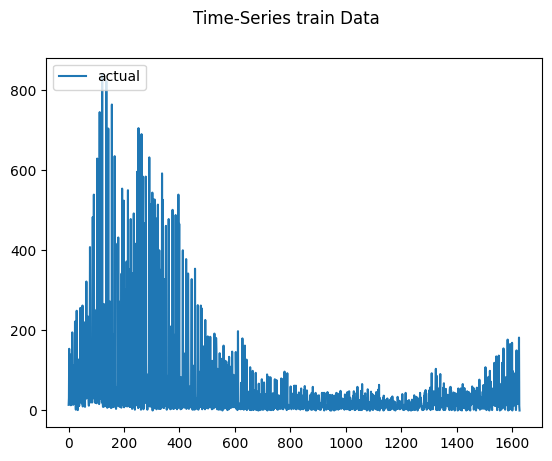

training the image model
training the second modality
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1000)           8092000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               3002000   
                                                                 
 dense (Dense)               (None, 250)               125250    
                                                                 
 batch_normalization (BatchN  (None, 250)              1000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 120)               30120     
                                                                 
 batch_normalization_1 (Batc  (None, 120)              480       
 h

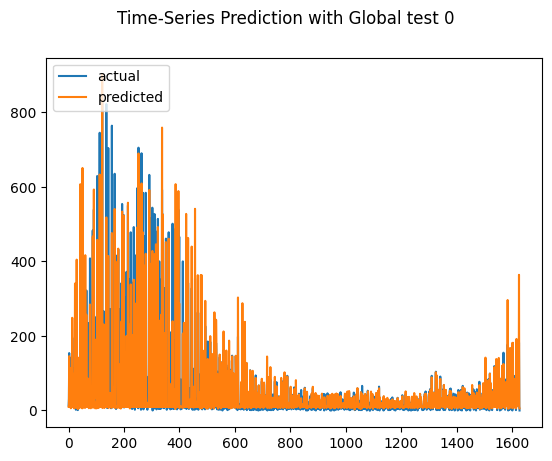

training the image model
training the second modality
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 1000)           8092000   
                                                                 
 lstm_5 (LSTM)               (None, 500)               3002000   
                                                                 
 dense_16 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_4 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_5 (Batc  (None, 120)              480       


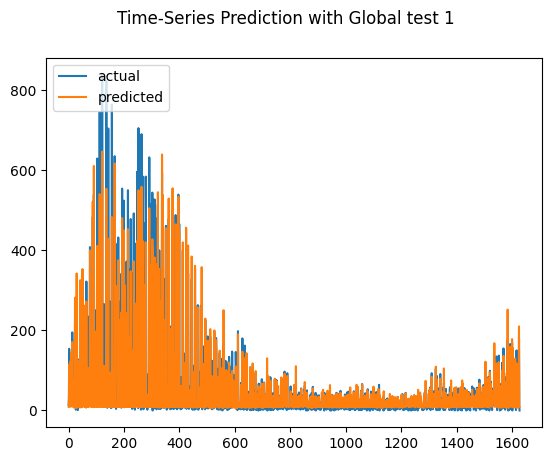

training the image model
training the second modality
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 1000)           8092000   
                                                                 
 lstm_9 (LSTM)               (None, 500)               3002000   
                                                                 
 dense_32 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_8 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                                 
 dense_33 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_9 (Batc  (None, 120)              480       

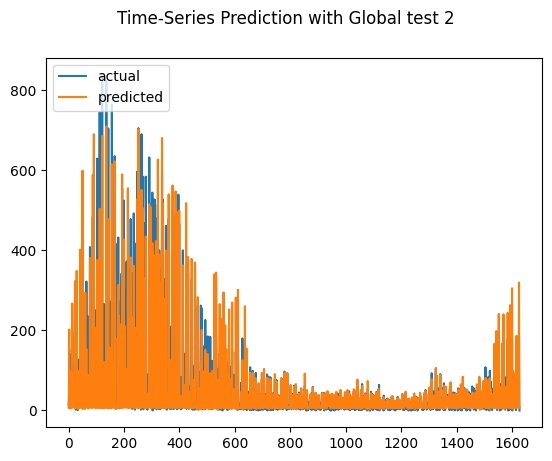

training the image model
training the second modality
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_13 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_48 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_12 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_49 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_13 (Bat  (None, 120)              480       

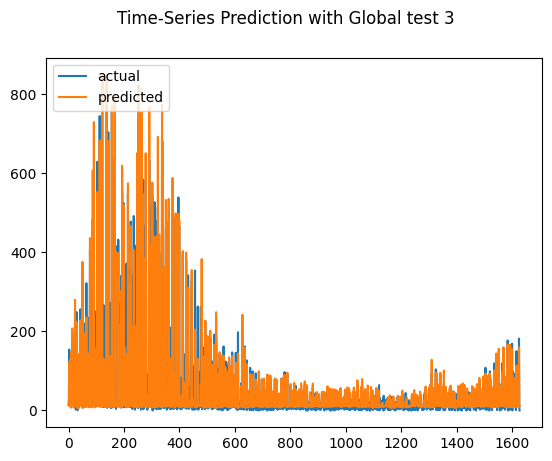

training the image model
training the second modality
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_17 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_64 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_16 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_65 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_17 (Bat  (None, 120)              480       

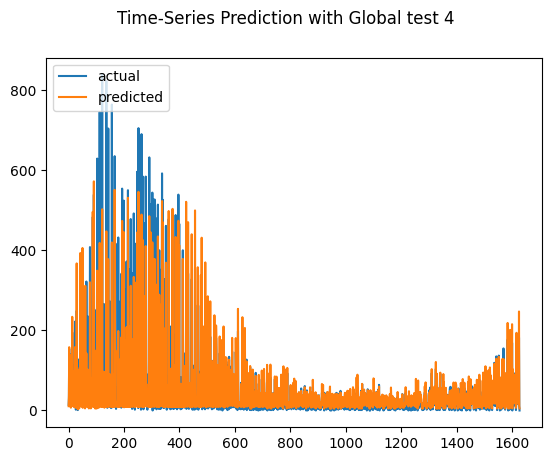

rmse : average=33.706, std=4.112
mae : average=15.205, std=1.094
smape : average=52.161, std=2.823
r2 : average=0.881, std=0.028
----------------------------------------------Fold 1:-----------------------------------------------
Shapes:   (546, 1051) (271, 1051)
  Train: 201546 to 201648
  Test: 201648 to 201723
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [96.03479853] [23845.0409136]


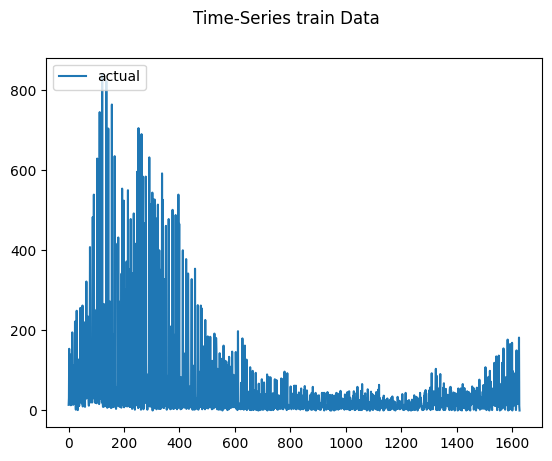

training the image model
training the second modality
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_21 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_80 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_20 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_81 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_21 (Bat  (None, 120)              480       

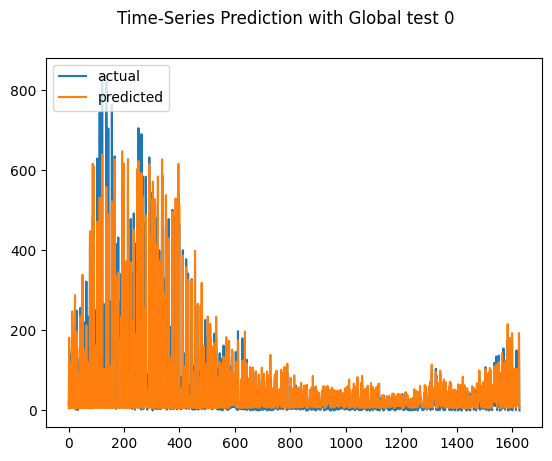

training the image model
training the second modality
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_25 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_96 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_24 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_97 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_25 (Bat  (None, 120)              480       

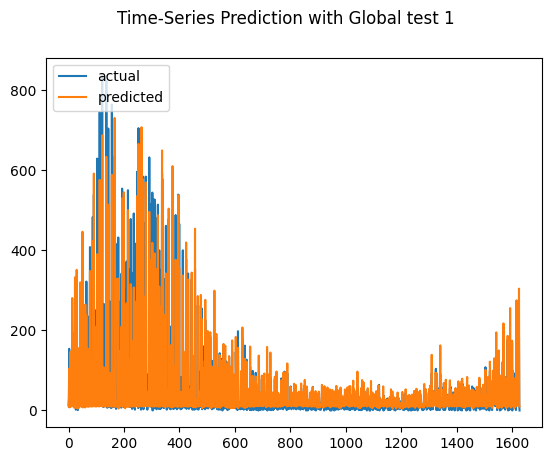

training the image model
training the second modality
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_29 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_112 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_28 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_113 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_29 (Bat  (None, 120)              480       

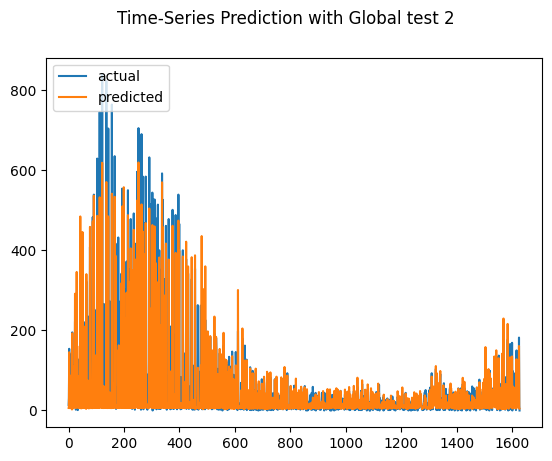

training the image model
training the second modality
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_33 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_128 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_32 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_129 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_33 (Bat  (None, 120)              480       

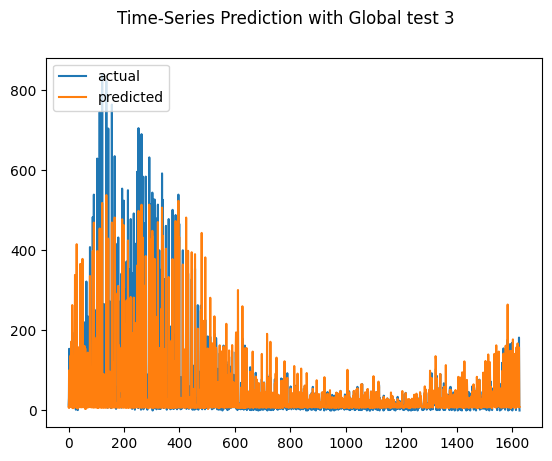

training the image model
training the second modality
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_37 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_144 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_36 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_145 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_37 (Bat  (None, 120)              480       

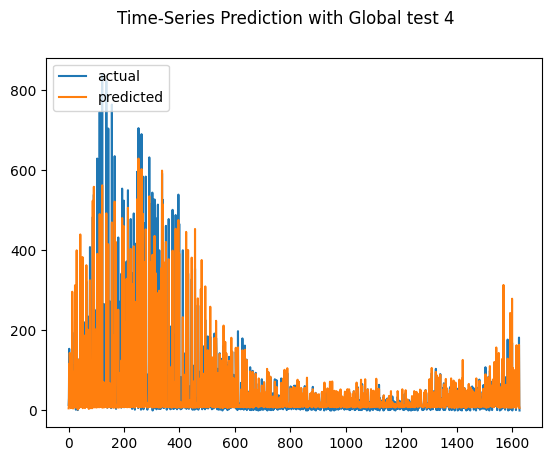

rmse : average=33.563, std=3.565
mae : average=15.460, std=0.654
smape : average=51.593, std=2.287
r2 : average=0.883, std=0.025
----------------------------------------------Fold 2:-----------------------------------------------
Shapes:   (817, 1051) (271, 1051)
  Train: 201546 to 201723
  Test: 201723 to 201750
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [72.44063647] [17498.39825076]


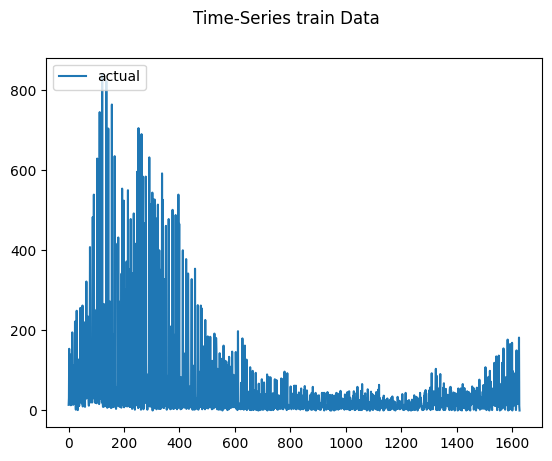

training the image model
training the second modality
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_41 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_160 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_40 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_161 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_41 (Bat  (None, 120)              480       

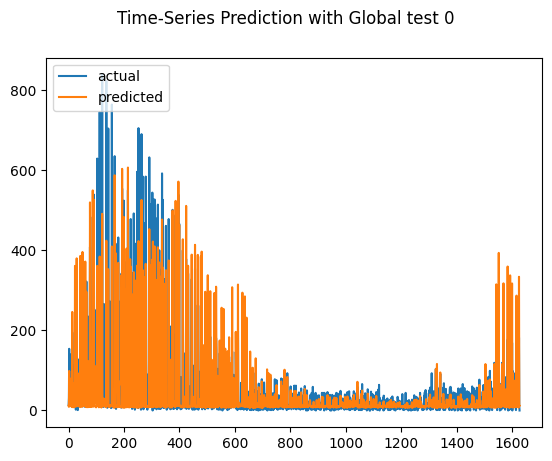

training the image model
training the second modality
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_45 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_176 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_44 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_177 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_45 (Bat  (None, 120)              480       

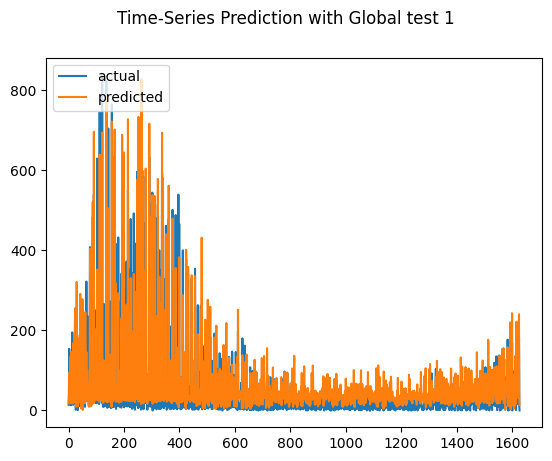

training the image model
training the second modality
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_49 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_192 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_48 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_193 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_49 (Bat  (None, 120)              480       

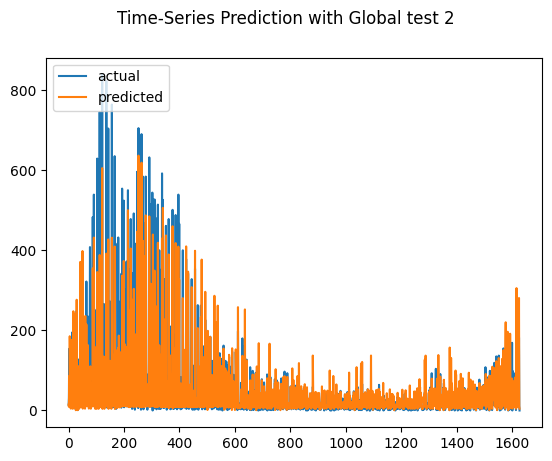

training the image model
training the second modality
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_53 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_208 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_52 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_209 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_53 (Bat  (None, 120)              480       

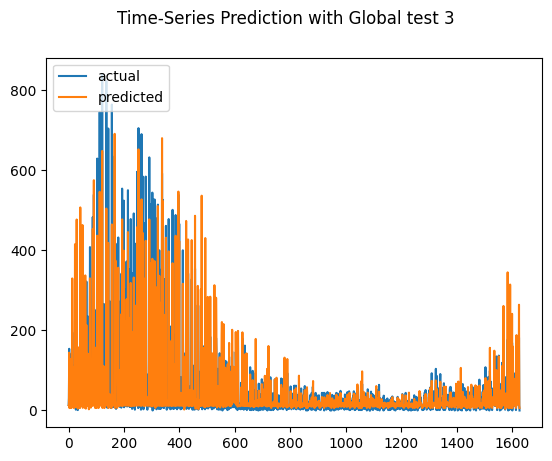

training the image model
training the second modality
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_57 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_224 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_56 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_225 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_57 (Bat  (None, 120)              480       

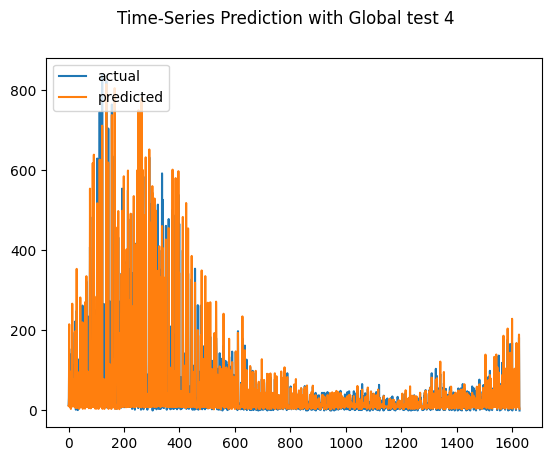

rmse : average=37.822, std=6.595
mae : average=19.205, std=3.839
smape : average=61.123, std=10.318
r2 : average=0.848, std=0.048
----------------------------------------------Fold 3:-----------------------------------------------
Shapes:   (1088, 1051) (271, 1051)
  Train: 201546 to 201750
  Test: 201750 to 201825
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [58.16268382] [13808.29982074]


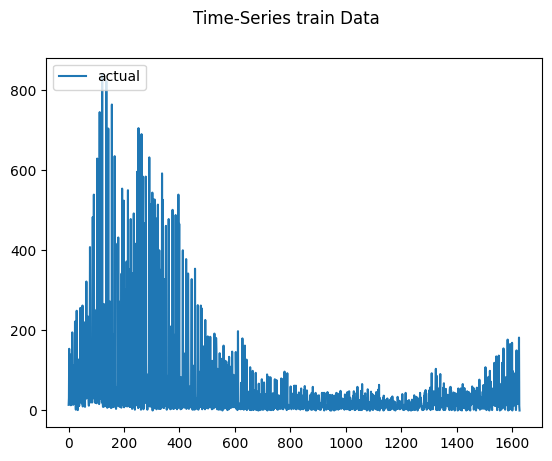

training the image model
training the second modality
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_61 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_240 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_60 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_241 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_61 (Bat  (None, 120)              480       

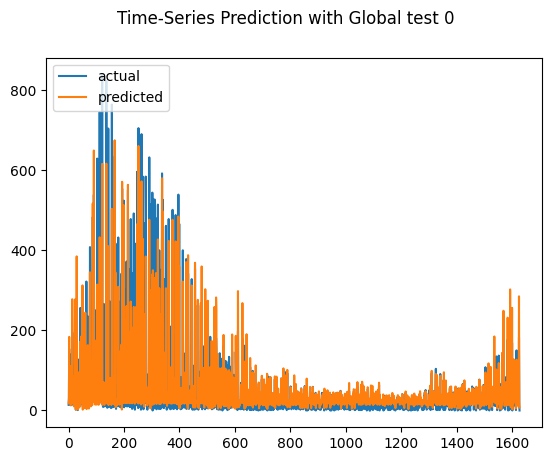

training the image model
training the second modality
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_65 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_256 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_64 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_257 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_65 (Bat  (None, 120)              480       

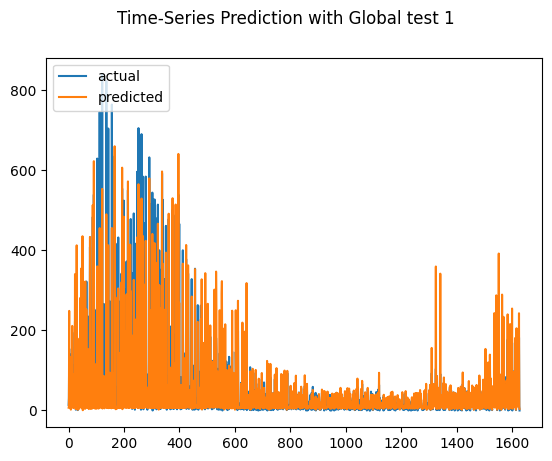

training the image model
training the second modality
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_69 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_272 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_68 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_273 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_69 (Bat  (None, 120)              480      

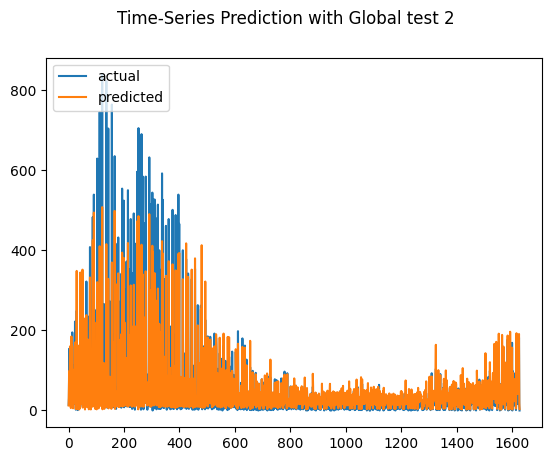

training the image model
training the second modality
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_73 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_288 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_72 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_289 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_73 (Bat  (None, 120)              480      

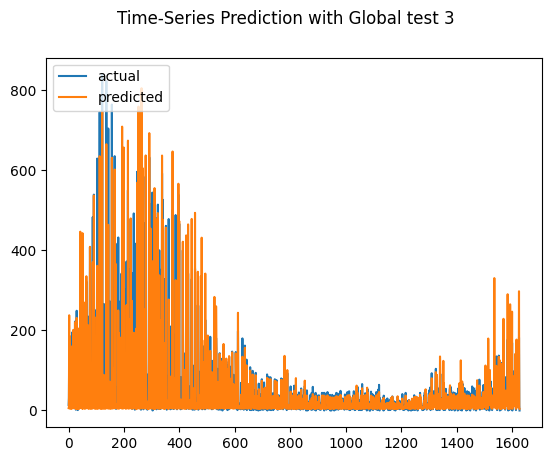

training the image model
training the second modality
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_77 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_304 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_76 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_305 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_77 (Bat  (None, 120)              480      

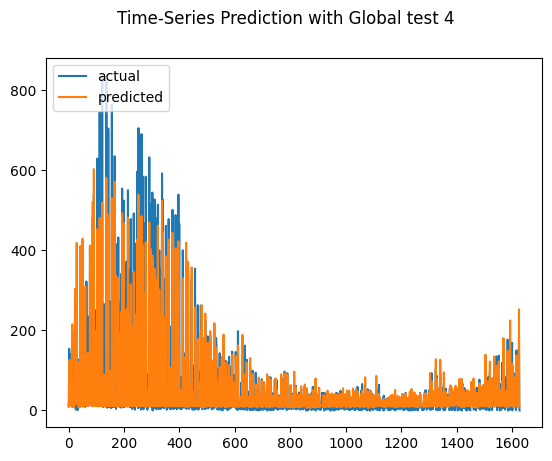

rmse : average=37.415, std=2.561
mae : average=17.234, std=1.308
smape : average=55.643, std=4.603
r2 : average=0.855, std=0.020
----------------------------------------------Fold 4:-----------------------------------------------
Shapes:   (1359, 1051) (271, 1051)
  Train: 201546 to 201825
  Test: 201825 to 201852
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [49.87711553] [11384.31676107]


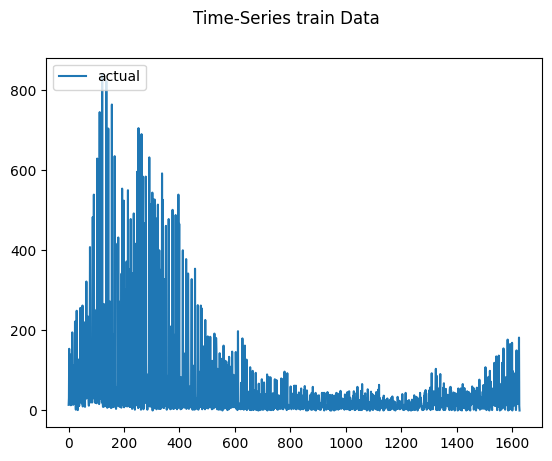

training the image model
training the second modality
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_81 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_320 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_80 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_321 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_81 (Bat  (None, 120)              480      

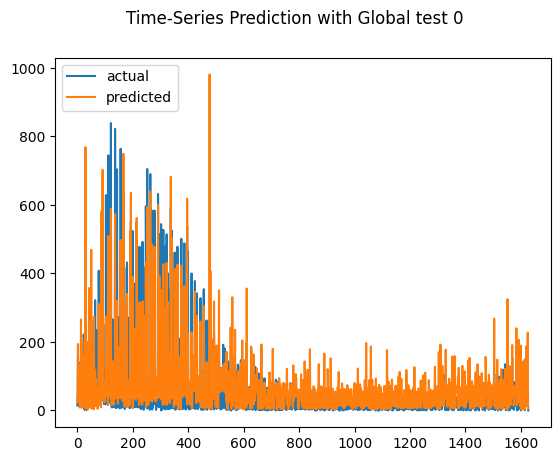

training the image model
training the second modality
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_85 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_336 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_84 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_337 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_85 (Bat  (None, 120)              480      

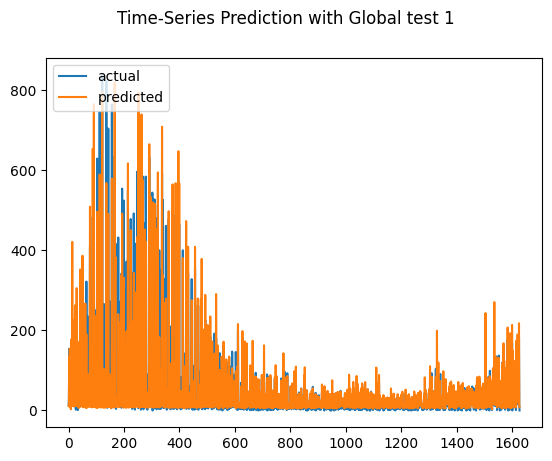

training the image model
training the second modality
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_89 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_352 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_88 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_353 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_89 (Bat  (None, 120)              480      

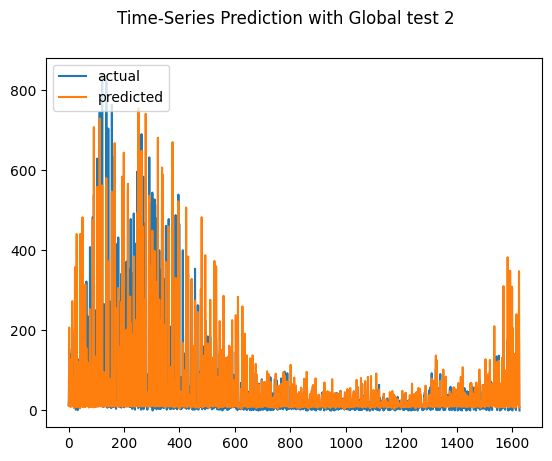

training the image model
training the second modality
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_93 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_368 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_92 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_369 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_93 (Bat  (None, 120)              480      

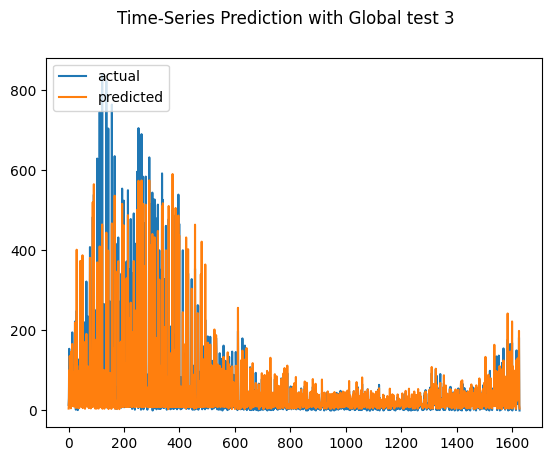

training the image model
training the second modality
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_97 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_384 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_96 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_385 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_97 (Bat  (None, 120)              480      

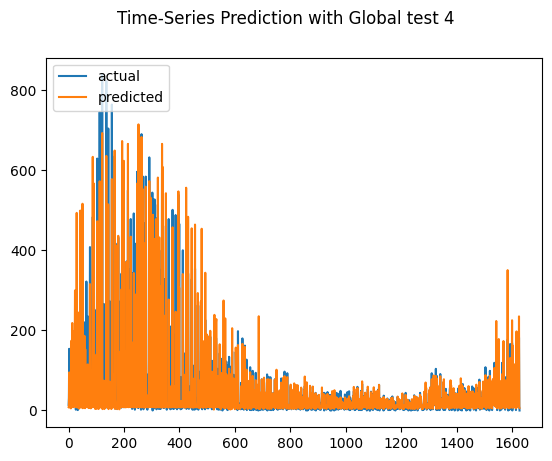

rmse : average=39.227, std=8.330
mae : average=19.730, std=8.898
smape : average=57.160, std=18.514
r2 : average=0.835, std=0.077


In [ ]:
full_metrics = time_cross_val(df, n_splits, dengue_df, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, n_tests=n_tests, fusion=fusion, epochs=150, batch_size=32)
mean = [[sum(values) / len(values) for values in zip(*sublist)] for sublist in zip(*full_metrics)]

In [ ]:
lstm_layers_gated = [1024,512,256]

## Late Dense Fusion with Attention (128)

----------------------------------------------Fold 0:-----------------------------------------------
Shapes:   (275, 1051) (271, 1051)
  Train: 201546 to 201621
  Test: 201621 to 201648
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [111.42181818] [27797.55297851]


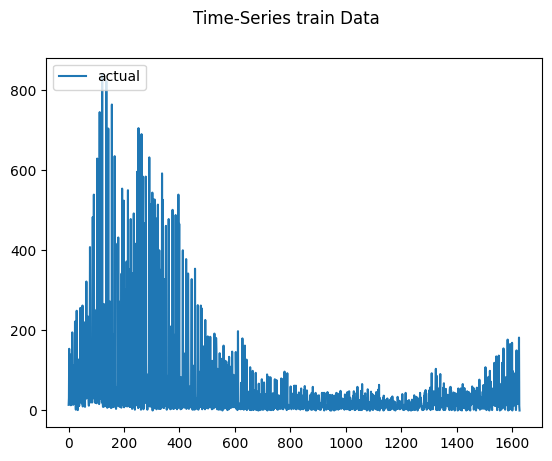

training the image model
training the second modality
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1000)           8092000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               3002000   
                                                                 
 dense (Dense)               (None, 250)               125250    
                                                                 
 batch_normalization (BatchN  (None, 250)              1000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 120)               30120     
                                                                 
 batch_normalization_1 (Batc  (None, 120)              480       
 h

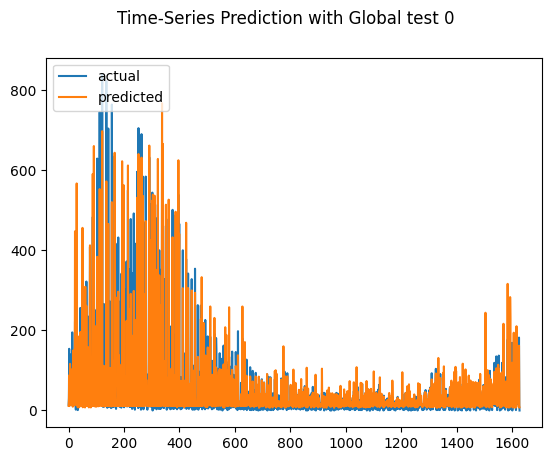

training the image model
training the second modality
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 1000)           8092000   
                                                                 
 lstm_5 (LSTM)               (None, 500)               3002000   
                                                                 
 dense_12 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_4 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_5 (Batc  (None, 120)              480       


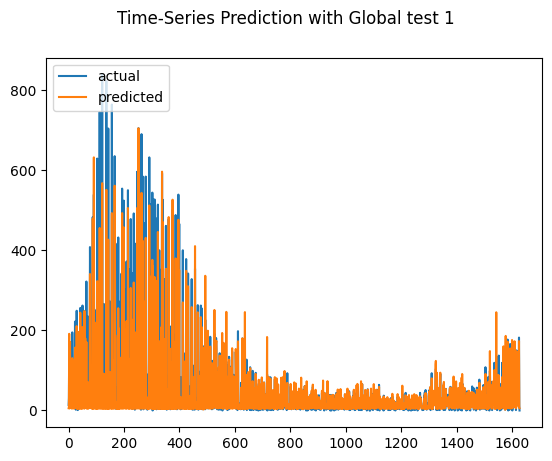

training the image model
training the second modality
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 1000)           8092000   
                                                                 
 lstm_9 (LSTM)               (None, 500)               3002000   
                                                                 
 dense_24 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_8 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_9 (Batc  (None, 120)              480       


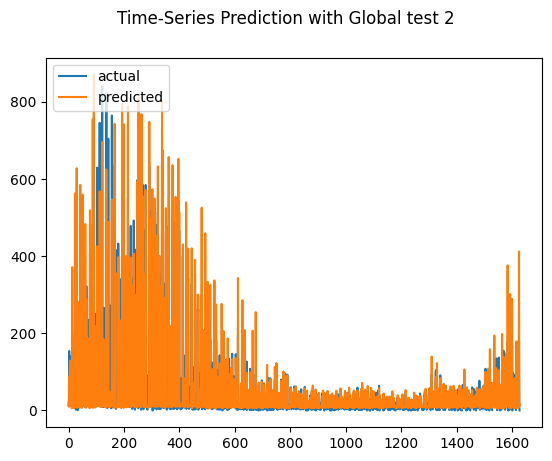

training the image model
training the second modality
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_13 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_36 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_12 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_13 (Bat  (None, 120)              480       

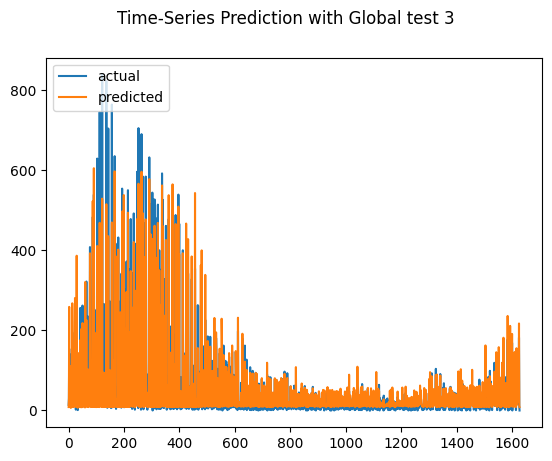

training the image model
training the second modality
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_17 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_48 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_16 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_49 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_17 (Bat  (None, 120)              480       

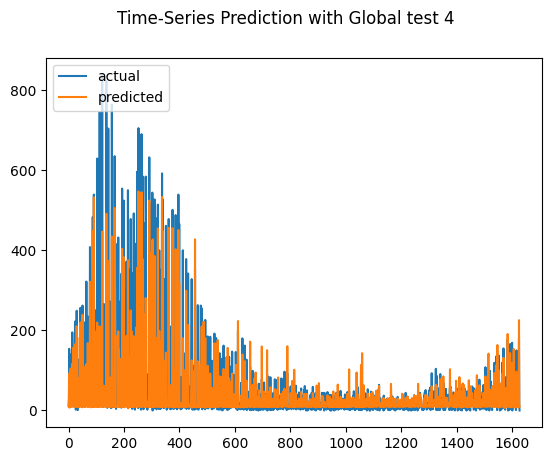

rmse : average=38.973, std=5.396
mae : average=17.247, std=2.040
smape : average=53.759, std=3.206
r2 : average=0.841, std=0.045
----------------------------------------------Fold 1:-----------------------------------------------
Shapes:   (546, 1051) (271, 1051)
  Train: 201546 to 201648
  Test: 201648 to 201723
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [96.03479853] [23845.0409136]


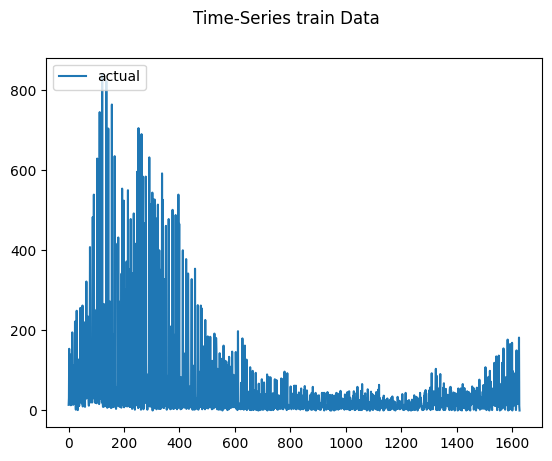

training the image model
training the second modality
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_21 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_60 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_20 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_61 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_21 (Bat  (None, 120)              480       

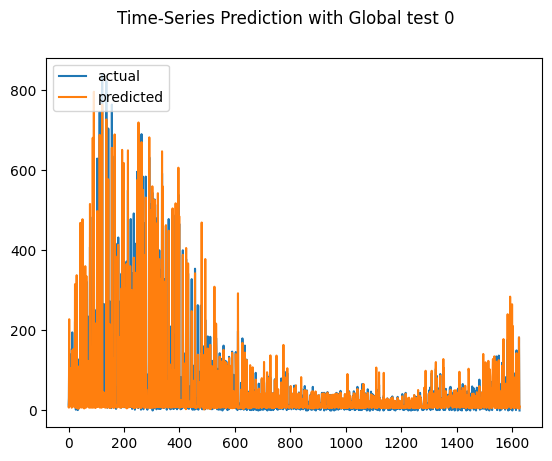

training the image model
training the second modality
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_25 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_72 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_24 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_73 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_25 (Bat  (None, 120)              480       

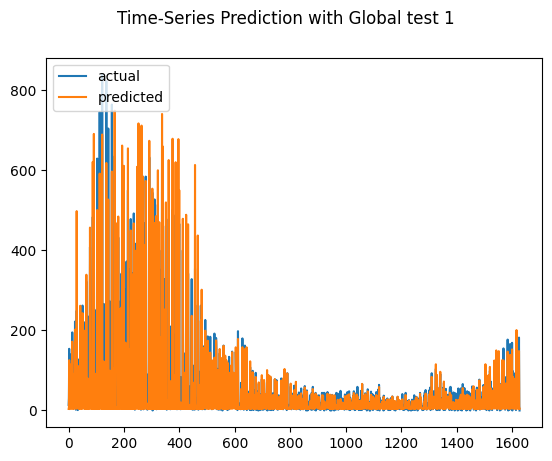

training the image model
training the second modality
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_29 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_84 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_28 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_85 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_29 (Bat  (None, 120)              480       

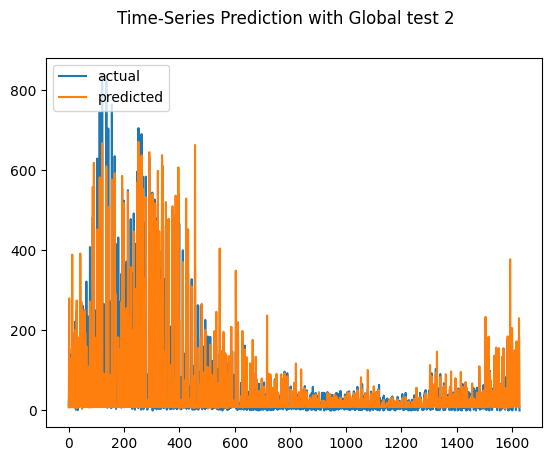

training the image model
training the second modality
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_33 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_96 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_32 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_97 (Dense)            (None, 120)               30120     
                                                                 
 batch_normalization_33 (Bat  (None, 120)              480       

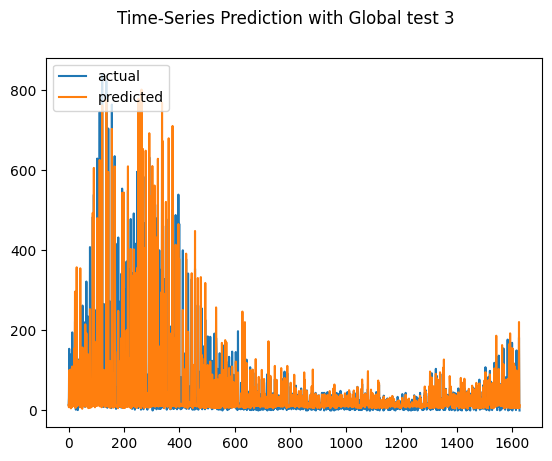

training the image model
training the second modality
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_37 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_108 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_36 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_109 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_37 (Bat  (None, 120)              480       

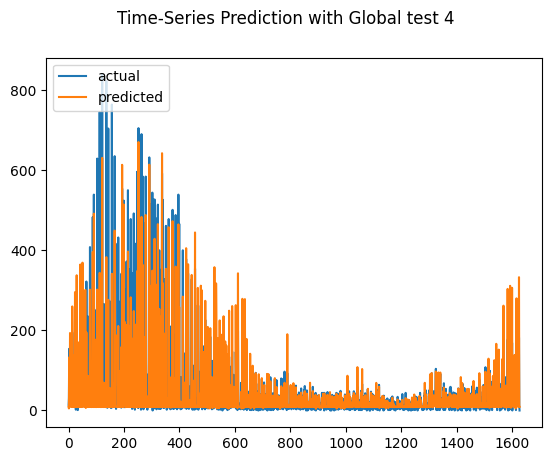

rmse : average=34.761, std=5.337
mae : average=16.051, std=1.426
smape : average=55.961, std=3.969
r2 : average=0.873, std=0.042
----------------------------------------------Fold 2:-----------------------------------------------
Shapes:   (817, 1051) (271, 1051)
  Train: 201546 to 201723
  Test: 201723 to 201750
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [72.44063647] [17498.39825076]


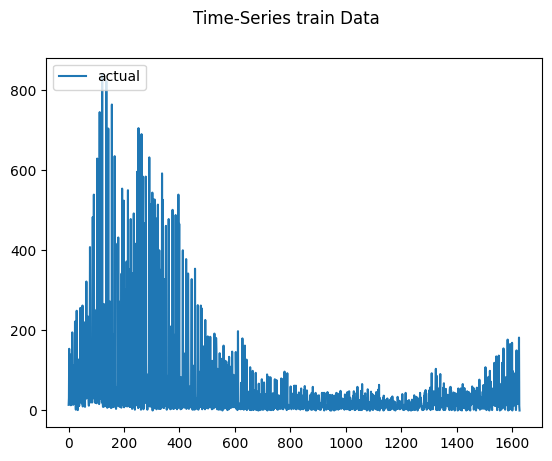

training the image model
training the second modality
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_41 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_120 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_40 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_121 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_41 (Bat  (None, 120)              480       

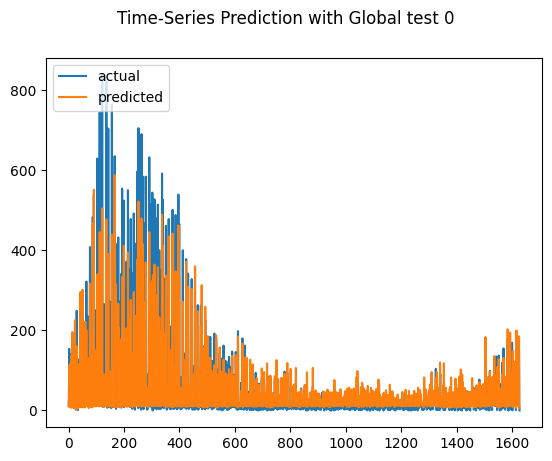

training the image model
training the second modality
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_45 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_132 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_44 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_133 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_45 (Bat  (None, 120)              480       

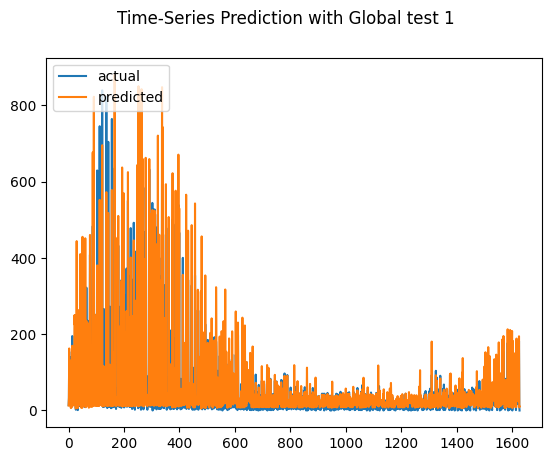

training the image model
training the second modality
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_49 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_144 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_48 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_145 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_49 (Bat  (None, 120)              480       

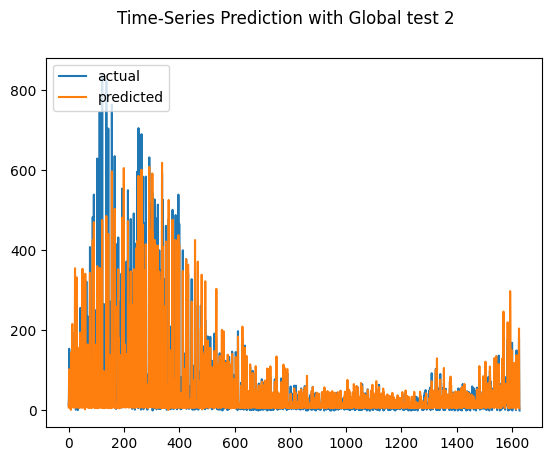

training the image model
training the second modality
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_53 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_156 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_52 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_157 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_53 (Bat  (None, 120)              480       

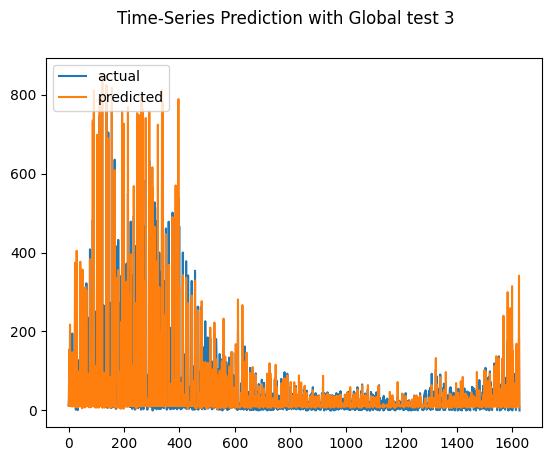

training the image model
training the second modality
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_57 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_168 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_56 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_169 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_57 (Bat  (None, 120)              480       

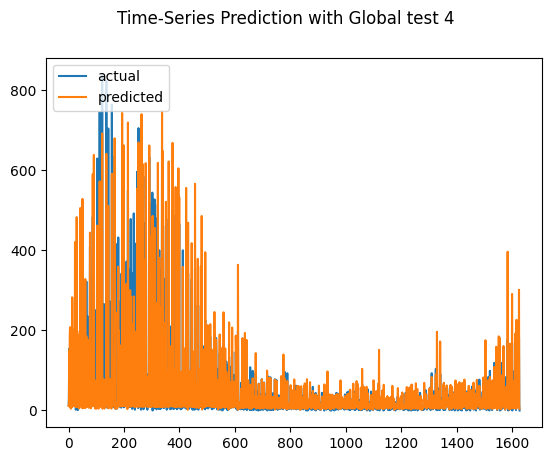

rmse : average=35.846, std=1.851
mae : average=16.698, std=0.980
smape : average=54.067, std=2.389
r2 : average=0.867, std=0.014
----------------------------------------------Fold 3:-----------------------------------------------
Shapes:   (1088, 1051) (271, 1051)
  Train: 201546 to 201750
  Test: 201750 to 201825
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [58.16268382] [13808.29982074]


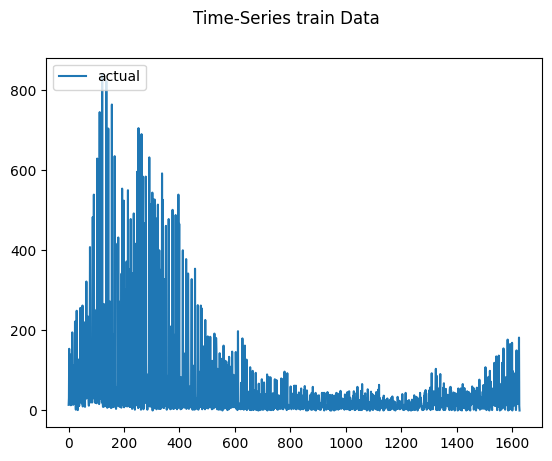

training the image model
training the second modality
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_61 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_180 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_60 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_181 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_61 (Bat  (None, 120)              480       

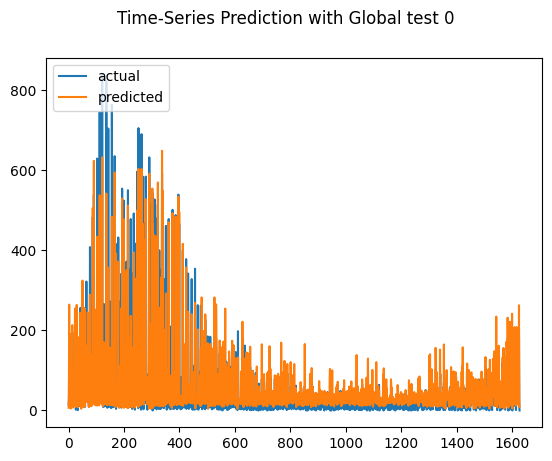

training the image model
training the second modality
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_65 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_192 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_64 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_193 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_65 (Bat  (None, 120)              480       

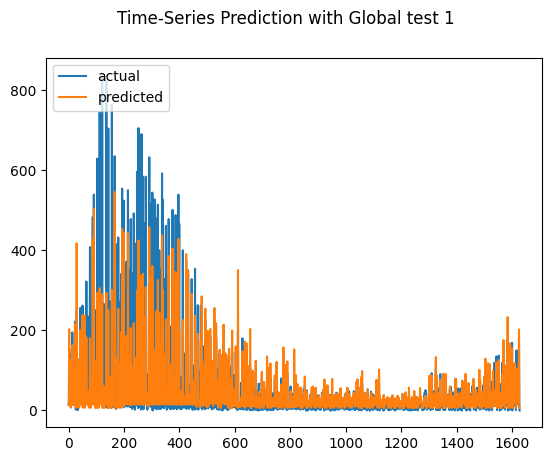

training the image model
training the second modality
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_69 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_204 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_68 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_205 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_69 (Bat  (None, 120)              480       

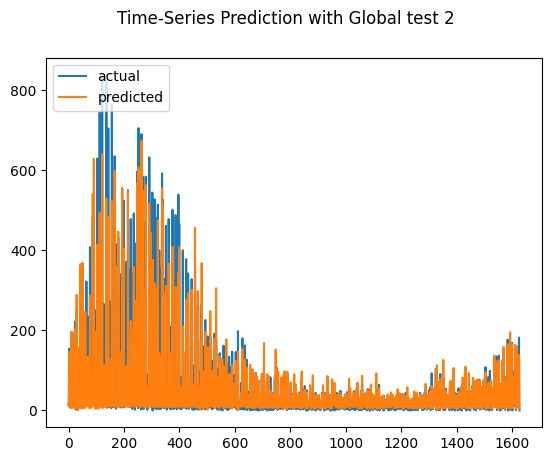

training the image model
training the second modality
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_73 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_216 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_72 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_217 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_73 (Bat  (None, 120)              480       

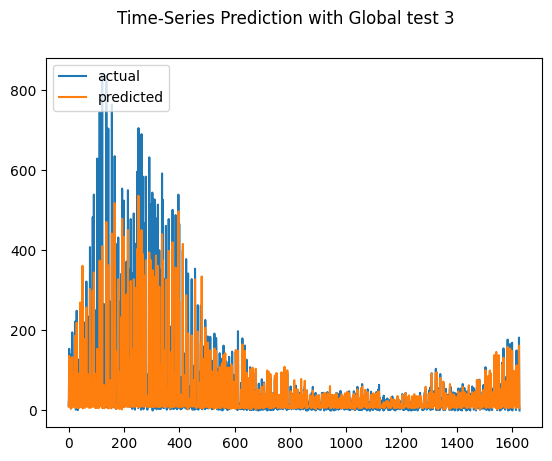

training the image model
training the second modality
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_77 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_228 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_76 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_229 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_77 (Bat  (None, 120)              480       

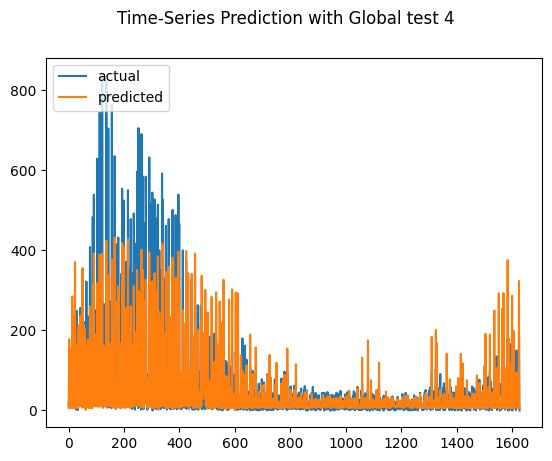

rmse : average=42.786, std=6.249
mae : average=18.902, std=1.819
smape : average=56.708, std=6.204
r2 : average=0.808, std=0.056
----------------------------------------------Fold 4:-----------------------------------------------
Shapes:   (1359, 1051) (271, 1051)
  Train: 201546 to 201825
  Test: 201825 to 201852
Supervised (1628, 3151), (1628, 3151)
Train:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
Test:
The shape of the features is (1628, 3150)
The shape of the labels is (1628, 1)
3D reshape: 
The initial shapes are:
The train shape is (1628, 3150)
The test shape is (1628, 3150)
-----------------------
The Final shapes are:
The train shape is (1628, 3, 1050)
The test shape is (1628, 3, 1050)
scaler------------ [49.87711553] [11384.31676107]


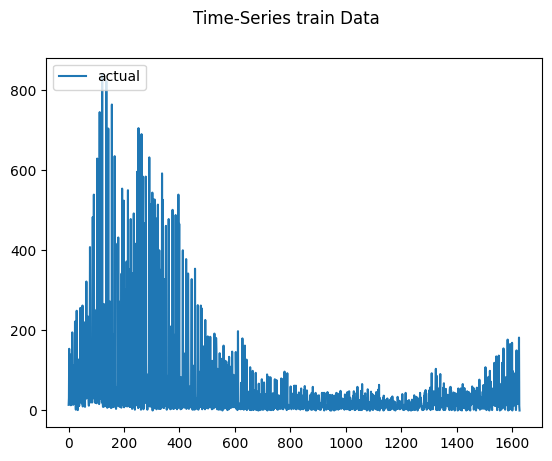

training the image model
training the second modality
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_81 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_240 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_80 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_241 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_81 (Bat  (None, 120)              480       

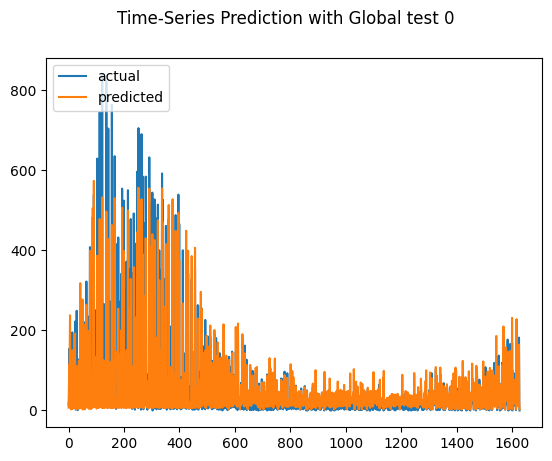

training the image model
training the second modality
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_85 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_252 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_84 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_253 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_85 (Bat  (None, 120)              480       

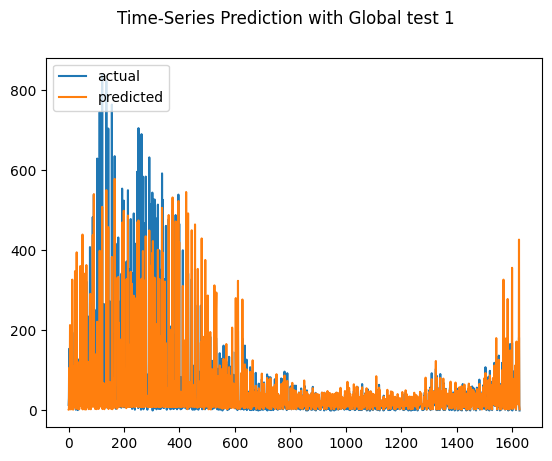

training the image model
training the second modality
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_89 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_264 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_88 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_265 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_89 (Bat  (None, 120)              480       

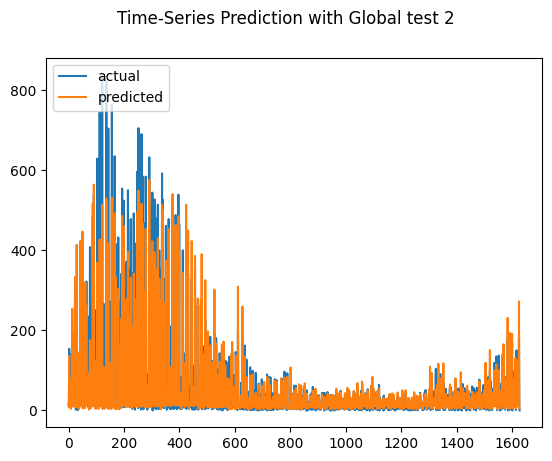

training the image model
training the second modality
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_93 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_276 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_92 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_277 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_93 (Bat  (None, 120)              480       

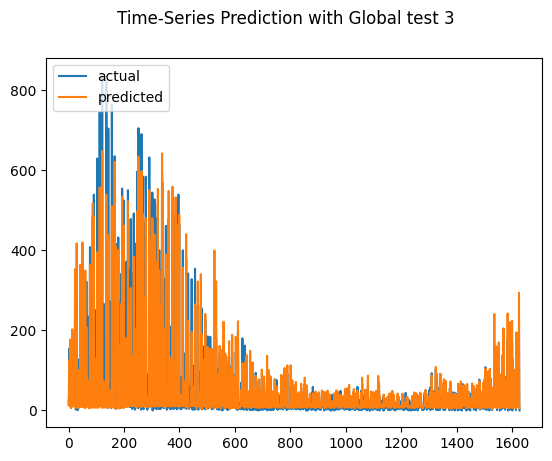

training the image model
training the second modality
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 3, 1000)           8092000   
                                                                 
 lstm_97 (LSTM)              (None, 500)               3002000   
                                                                 
 dense_288 (Dense)           (None, 250)               125250    
                                                                 
 batch_normalization_96 (Bat  (None, 250)              1000      
 chNormalization)                                                
                                                                 
 dense_289 (Dense)           (None, 120)               30120     
                                                                 
 batch_normalization_97 (Bat  (None, 120)              480       

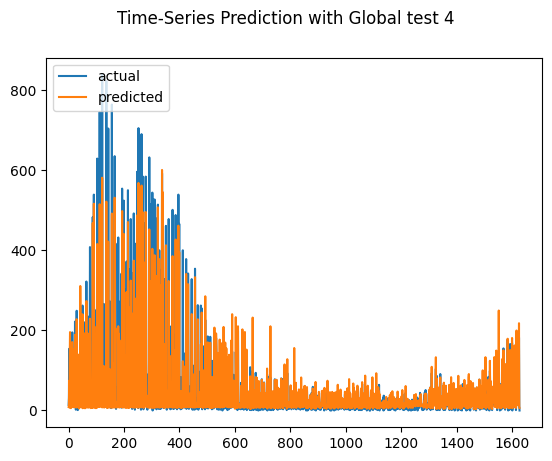

rmse : average=36.773, std=2.758
mae : average=16.548, std=1.045
smape : average=52.881, std=4.115
r2 : average=0.860, std=0.022


In [ ]:
full_metrics = time_cross_val(df, n_splits, dengue_df, lstm_layers, nn_layers, dense_acivation, recurrent_cells, bidirectional, n_tests=n_tests, fusion=fusion, epochs=150, batch_size=32)
mean = [[sum(values) / len(values) for values in zip(*sublist)] for sublist in zip(*full_metrics)]